<a href="https://www.kaggle.com/code/rubinr12/faang-stocks-lstm-arima-prophet?scriptVersionId=190483007" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Installing the Necessary Libraries

In [4]:
#install the libraries -q for quiet installation (Ignore the warnings)
!pip install mplfinance -q
!pip install pmdarima -q
!pip install prophet -q

# Imports

In [1]:
#Import the libraries
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates


import datetime
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from mplfinance.original_flavor import candlestick_ohlc

import keras
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from prophet import Prophet
from prophet.plot import plot_plotly

ModuleNotFoundError: No module named 'mplfinance'

# Exploratory Data Analysis (EDA)
Before we start predicting stock prices of the FAANG companies we need to explore the dataset first. We will be considering the `Date`, `Open`, `High`, `Low`, `Close` and `Volume` columns of the dataset while performing our analysis.

[Kaggle dataset](https://www.kaggle.com/datasets/paultimothymooney/stock-market-data)

In [30]:
# Path to the dataset
dataset_path = '../input/stock-market-data/stock_market_data'
csv_folder = 'csv'
# file_name = 'AAPL.csv'

# Define the folders
folders = ['forbes2000','nasdaq', 'nyse', 'sp500']

# Print a menu to choose a folder
print("Choose a folder:")
for i, folder in enumerate(folders):
    print(f"{i+1}. {folder}")

# Get the user's choice
while True:
    choice = input("Enter the number of your choice: ")
    if choice.isdigit() and 1 <= int(choice) <= len(folders):
        break
    else:
        print("Invalid choice. Please try again.")

# Get the selected folder
selected_folder = folders[int(choice) - 1]

# Construct the full file path
file_path = os.path.join(dataset_path, selected_folder, csv_folder)

Choose a folder:
1. forbes2000
2. nasdaq
3. nyse
4. sp500


Enter the number of your choice:  2


In [31]:
#Load the data
df_meta = pd.read_csv(os.path.join(dirname, 'META.csv'))
df_aapl = pd.read_csv(os.path.join(dirname, 'AAPL.csv'))
df_amzn = pd.read_csv(os.path.join(dirname, 'AMZN.csv'))
df_nflx = pd.read_csv(os.path.join(dirname, 'NFLX.csv'))
df_goog = pd.read_csv(os.path.join(dirname, 'GOOG.csv'))

#Parse the data and get the start date and end date
print('\t\tStart Date\t\tEnd Date')
print('META\t\t{}\t\t{}'.format(df_meta['Date'][0], df_meta.iloc[-1, 0]))
print('AAPL\t\t{}\t\t{}'.format(df_aapl['Date'][0], df_aapl.iloc[-1, 0]))
print('AMZN\t\t{}\t\t{}'.format(df_amzn['Date'][0], df_amzn.iloc[-1, 0]))
print('NFLX\t\t{}\t\t{}'.format(df_nflx['Date'][0], df_nflx.iloc[-1, 0]))
print('GOOG\t\t{}\t\t{}'.format(df_goog['Date'][0], df_goog.iloc[-1, 0]))

df_meta['Date'] = df_meta.Date.apply(parse)
df_aapl['Date'] = df_aapl.Date.apply(parse)
df_amzn['Date'] = df_amzn.Date.apply(parse)
df_nflx['Date'] = df_nflx.Date.apply(parse)
df_goog['Date'] = df_goog.Date.apply(parse)

		Start Date		End Date
META		2012-05-18		2022-07-12
AAPL		1980-12-12		2022-07-12
AMZN		1997-05-15		2022-07-12
NFLX		2002-05-23		2022-07-12
GOOG		2004-08-19		2022-07-12


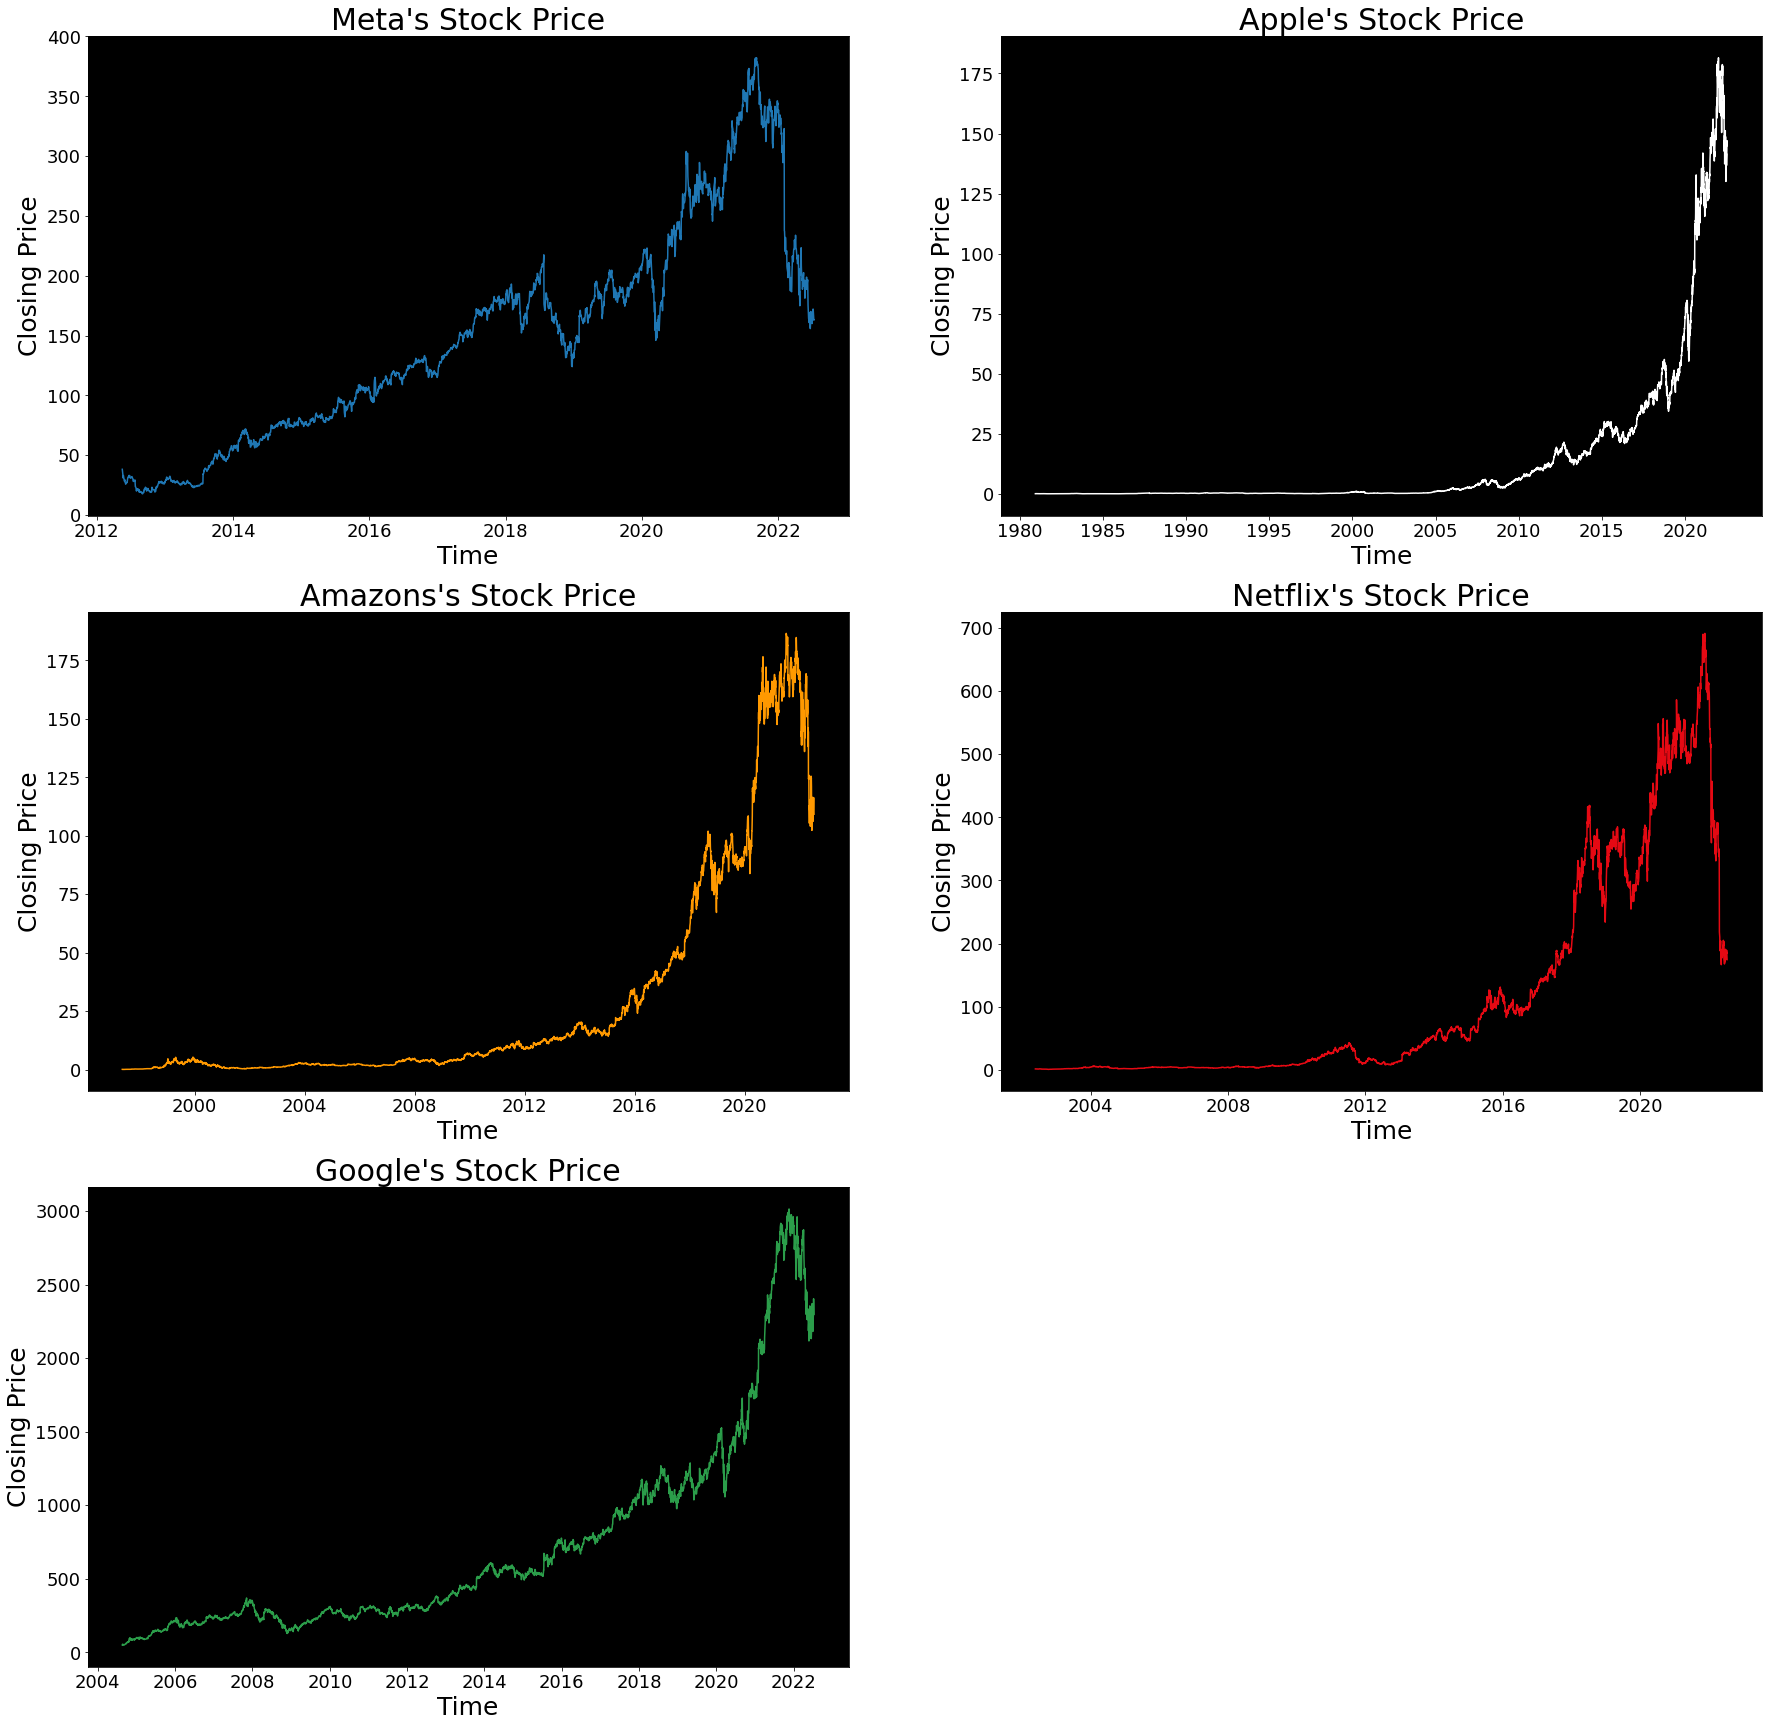

In [32]:
# Function to visualise the FAANG stock price
def visualize_faang_stock_prices(df_meta, df_aapl, df_amzn, df_nflx, df_goog):
# Setting the plot size
    fig, axes = plt.subplots(3, 2, figsize = (30, 30)) 
    axes[2][1].set_visible(False)
# Meta
    axes[0][0].set_facecolor('black')
    axes[0][0].plot(df_meta['Date'], df_meta['Close'])
    axes[0][0].set_title("Meta's Stock Price", fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Closing Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
# Apple    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(df_aapl['Date'], df_aapl['Close'], color = 'white')
    axes[0][1].set_title("Apple's Stock Price", fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Closing Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
# Amazon
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(df_amzn['Date'], df_amzn['Close'], color = '#FF9900')
    axes[1][0].set_title("Amazons's Stock Price", fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Closing Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
# Netflix
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(df_nflx['Date'], df_nflx['Close'], color = '#E50913')
    axes[1][1].set_title("Netflix's Stock Price", fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Closing Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
# Google
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(df_goog['Date'], df_goog['Close'], color = '#2B9D4A')
    axes[2][0].set_title("Google's Stock Price", fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Closing Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)

    plt.show()
    
visualize_faang_stock_prices(df_meta, df_aapl, df_amzn, df_nflx, df_goog)

**Observations**: We begin by analyzing the **Closing Price** of the companies. The closing price is the last price at which a stock traded during the regular trading day. A stock's closing price is the standard benchmark used by investors to track its performance over time. As we can observe from the graphs the closing price of all the stocks has reduced significantly from 2020 to 2022. This can be attributed to the COVID-19 pandemic that led to a stock market crash.

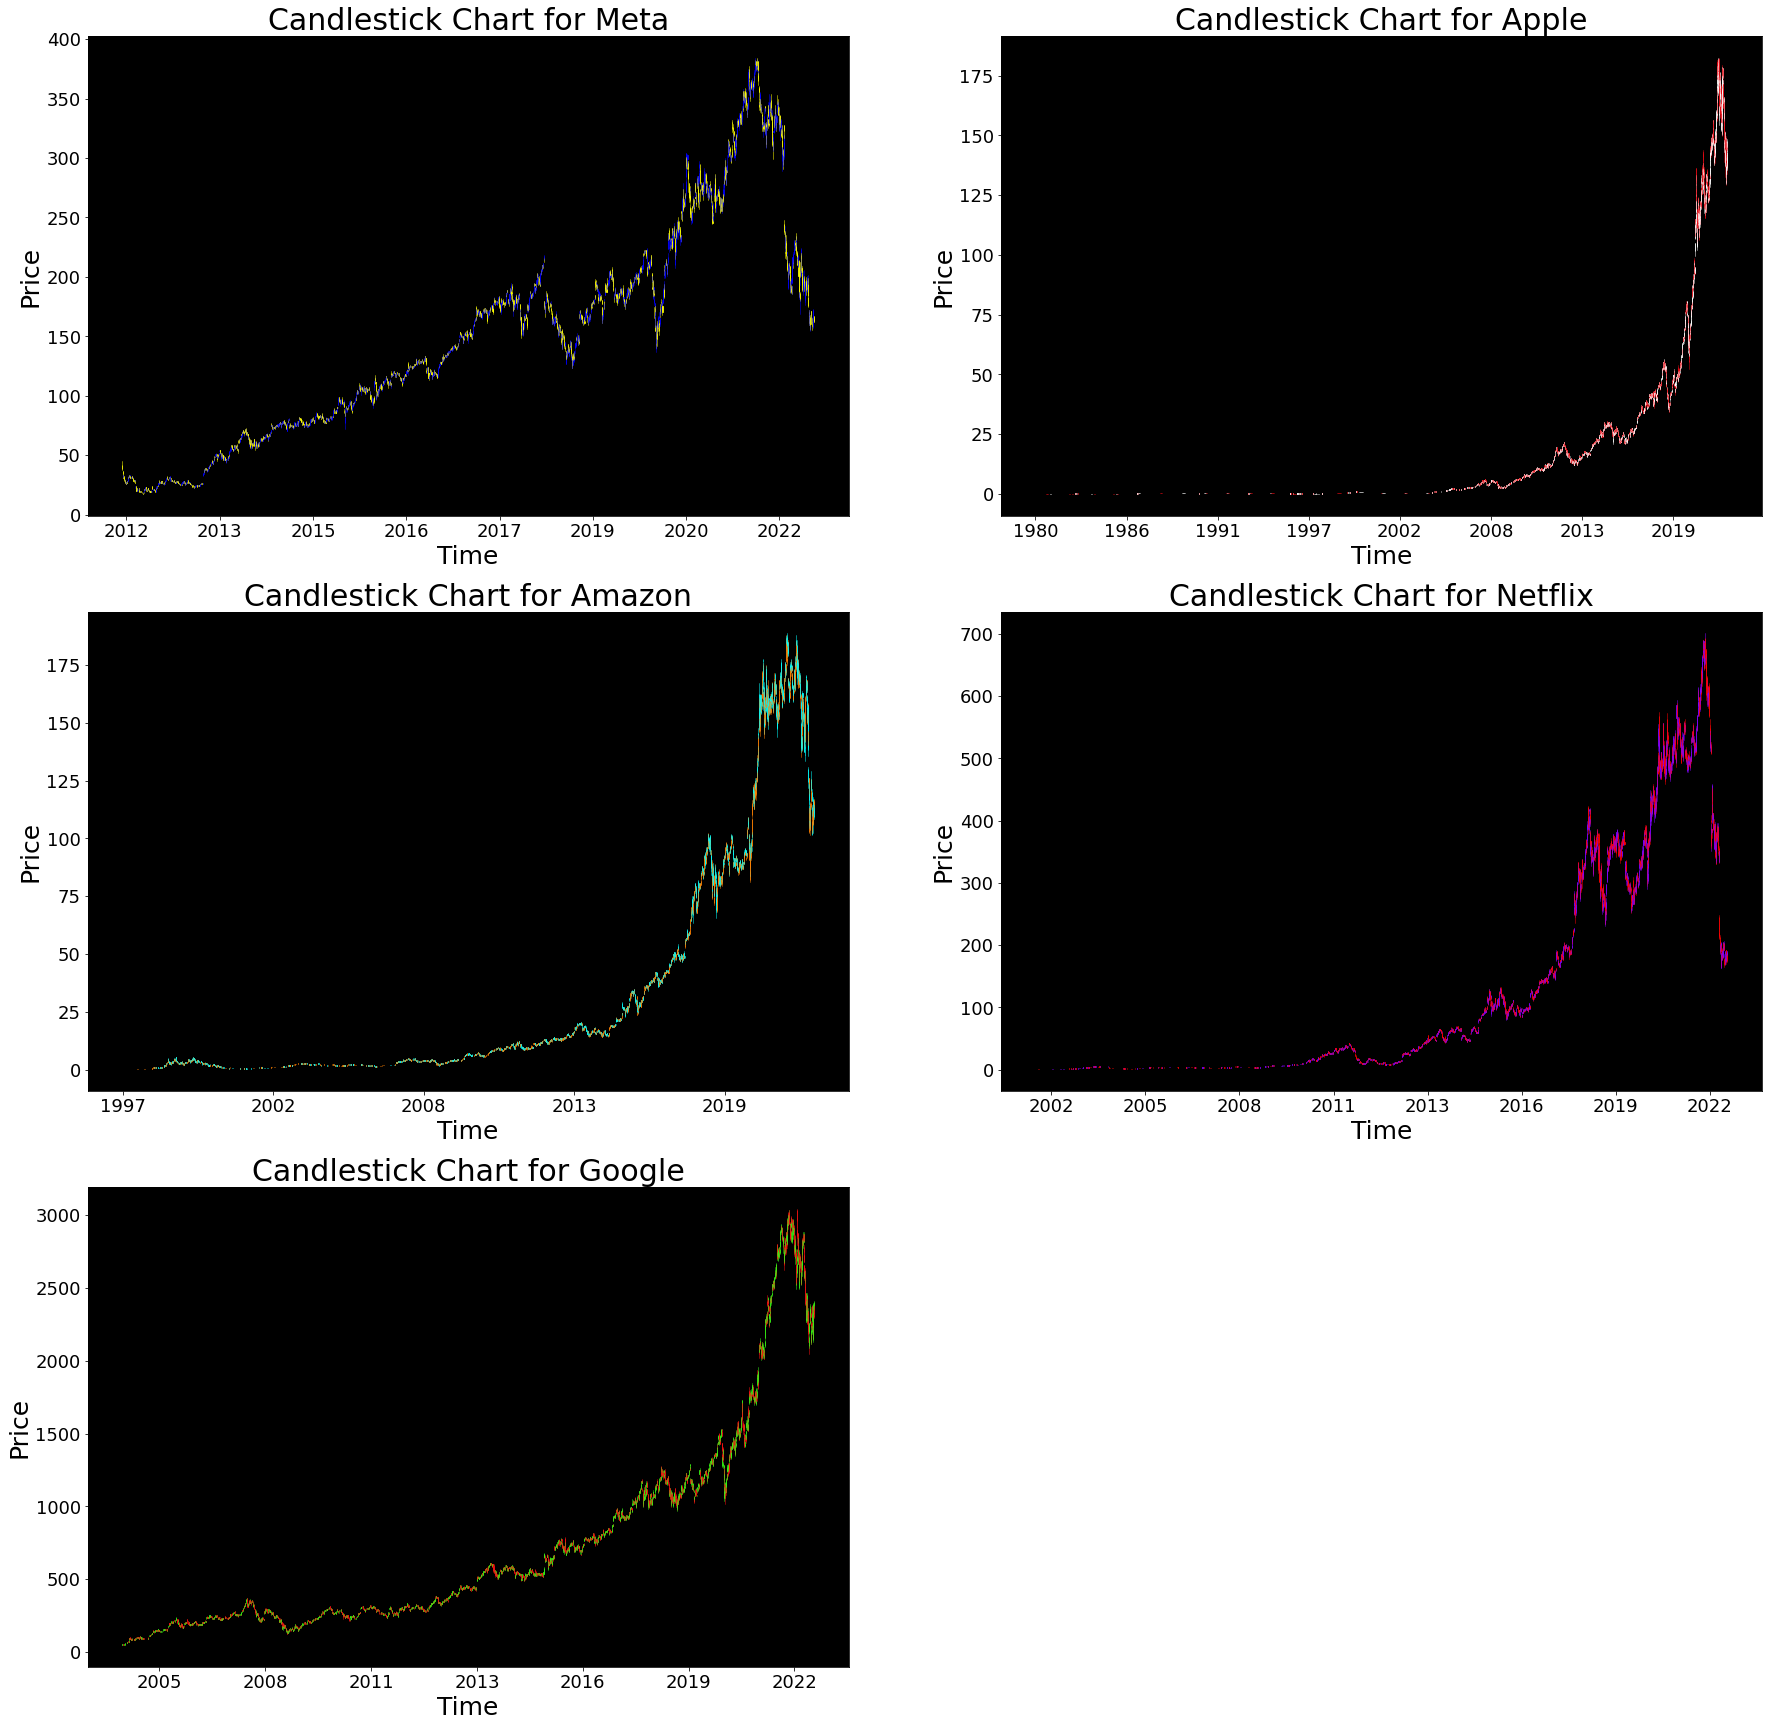

In [33]:
# Plot the candlestick chart for FAANG stock price
def visualize_faang_candlestick_charts(df_meta, df_aapl, df_amzn, df_nflx, df_goog):

    candlestick_chart_data = ['Date', 'Open', 'High', 'Low', 'Close']
#Subset the data only for the above columns
    new_meta_df = df_meta[candlestick_chart_data]
    new_aapl_df = df_aapl[candlestick_chart_data]
    new_amzn_df = df_amzn[candlestick_chart_data]
    new_nflx_df = df_nflx[candlestick_chart_data]
    new_goog_df = df_goog[candlestick_chart_data]

    new_meta_df['Date'] = new_meta_df['Date'].map(mpdates.date2num)
    new_aapl_df['Date'] = new_aapl_df['Date'].map(mpdates.date2num)
    new_amzn_df['Date'] = new_amzn_df['Date'].map(mpdates.date2num)
    new_nflx_df['Date'] = new_nflx_df['Date'].map(mpdates.date2num)
    new_goog_df['Date'] = new_goog_df['Date'].map(mpdates.date2num)

    fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    axes[2][1].set_visible(False)
#Plot the data
# Meta
    axes[0][0].set_facecolor('black')
    date_format = mpdates.DateFormatter('%Y')
    axes[0][0].xaxis.set_major_formatter(date_format)
    candlestick_ohlc(axes[0][0], new_meta_df.values, colorup = '#0000FF', colordown = '#FFFF00', alpha = 0.8)
    axes[0][0].set_title('Candlestick Chart for Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
# Apple
    axes[0][1].set_facecolor('black')
    date_format = mpdates.DateFormatter('%Y')
    axes[0][1].xaxis.set_major_formatter(date_format)
    candlestick_ohlc(axes[0][1], new_aapl_df.values, colorup = '#FFFFFF', colordown = '#E50913', alpha = 0.8)
    axes[0][1].set_title('Candlestick Chart for Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
# Amazon
    axes[1][0].set_facecolor('black')
    date_format = mpdates.DateFormatter('%Y')
    axes[1][0].xaxis.set_major_formatter(date_format)
    candlestick_ohlc(axes[1][0], new_amzn_df.values, colorup = '#FF8000', colordown = '#01FFFF', alpha = 0.8)
    axes[1][0].set_title('Candlestick Chart for Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
# Netflix
    axes[1][1].set_facecolor('black')
    date_format = mpdates.DateFormatter('%Y')
    axes[1][1].xaxis.set_major_formatter(date_format)
    candlestick_ohlc(axes[1][1], new_nflx_df.values, colorup = '#8000FF', colordown = '#FF0000', alpha = 0.8)
    axes[1][1].set_title('Candlestick Chart for Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
# Google
    axes[2][0].set_facecolor('black')
    date_format = mpdates.DateFormatter('%Y')
    axes[2][0].xaxis.set_major_formatter(date_format)
    candlestick_ohlc(axes[2][0], new_goog_df.values, colorup = '#37F713', colordown = '#F71111', alpha = 0.8)
    axes[2][0].set_title('Candlestick Chart for Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)

    plt.show()
    
visualize_faang_candlestick_charts(df_meta, df_aapl, df_amzn, df_nflx, df_goog)

**Observations**: An **OHLC** (Open High Low Close) chart is a type of chart typically used to illustrate movements in the price of a financial instrument over time. Each vertical line on the chart shows the price range (the highest and lowest prices) over one unit of time. Similar to the Closing Prices graph we can observe a significant decline in the OHLC charts from 2020 to 2022, due to the global pandemic.

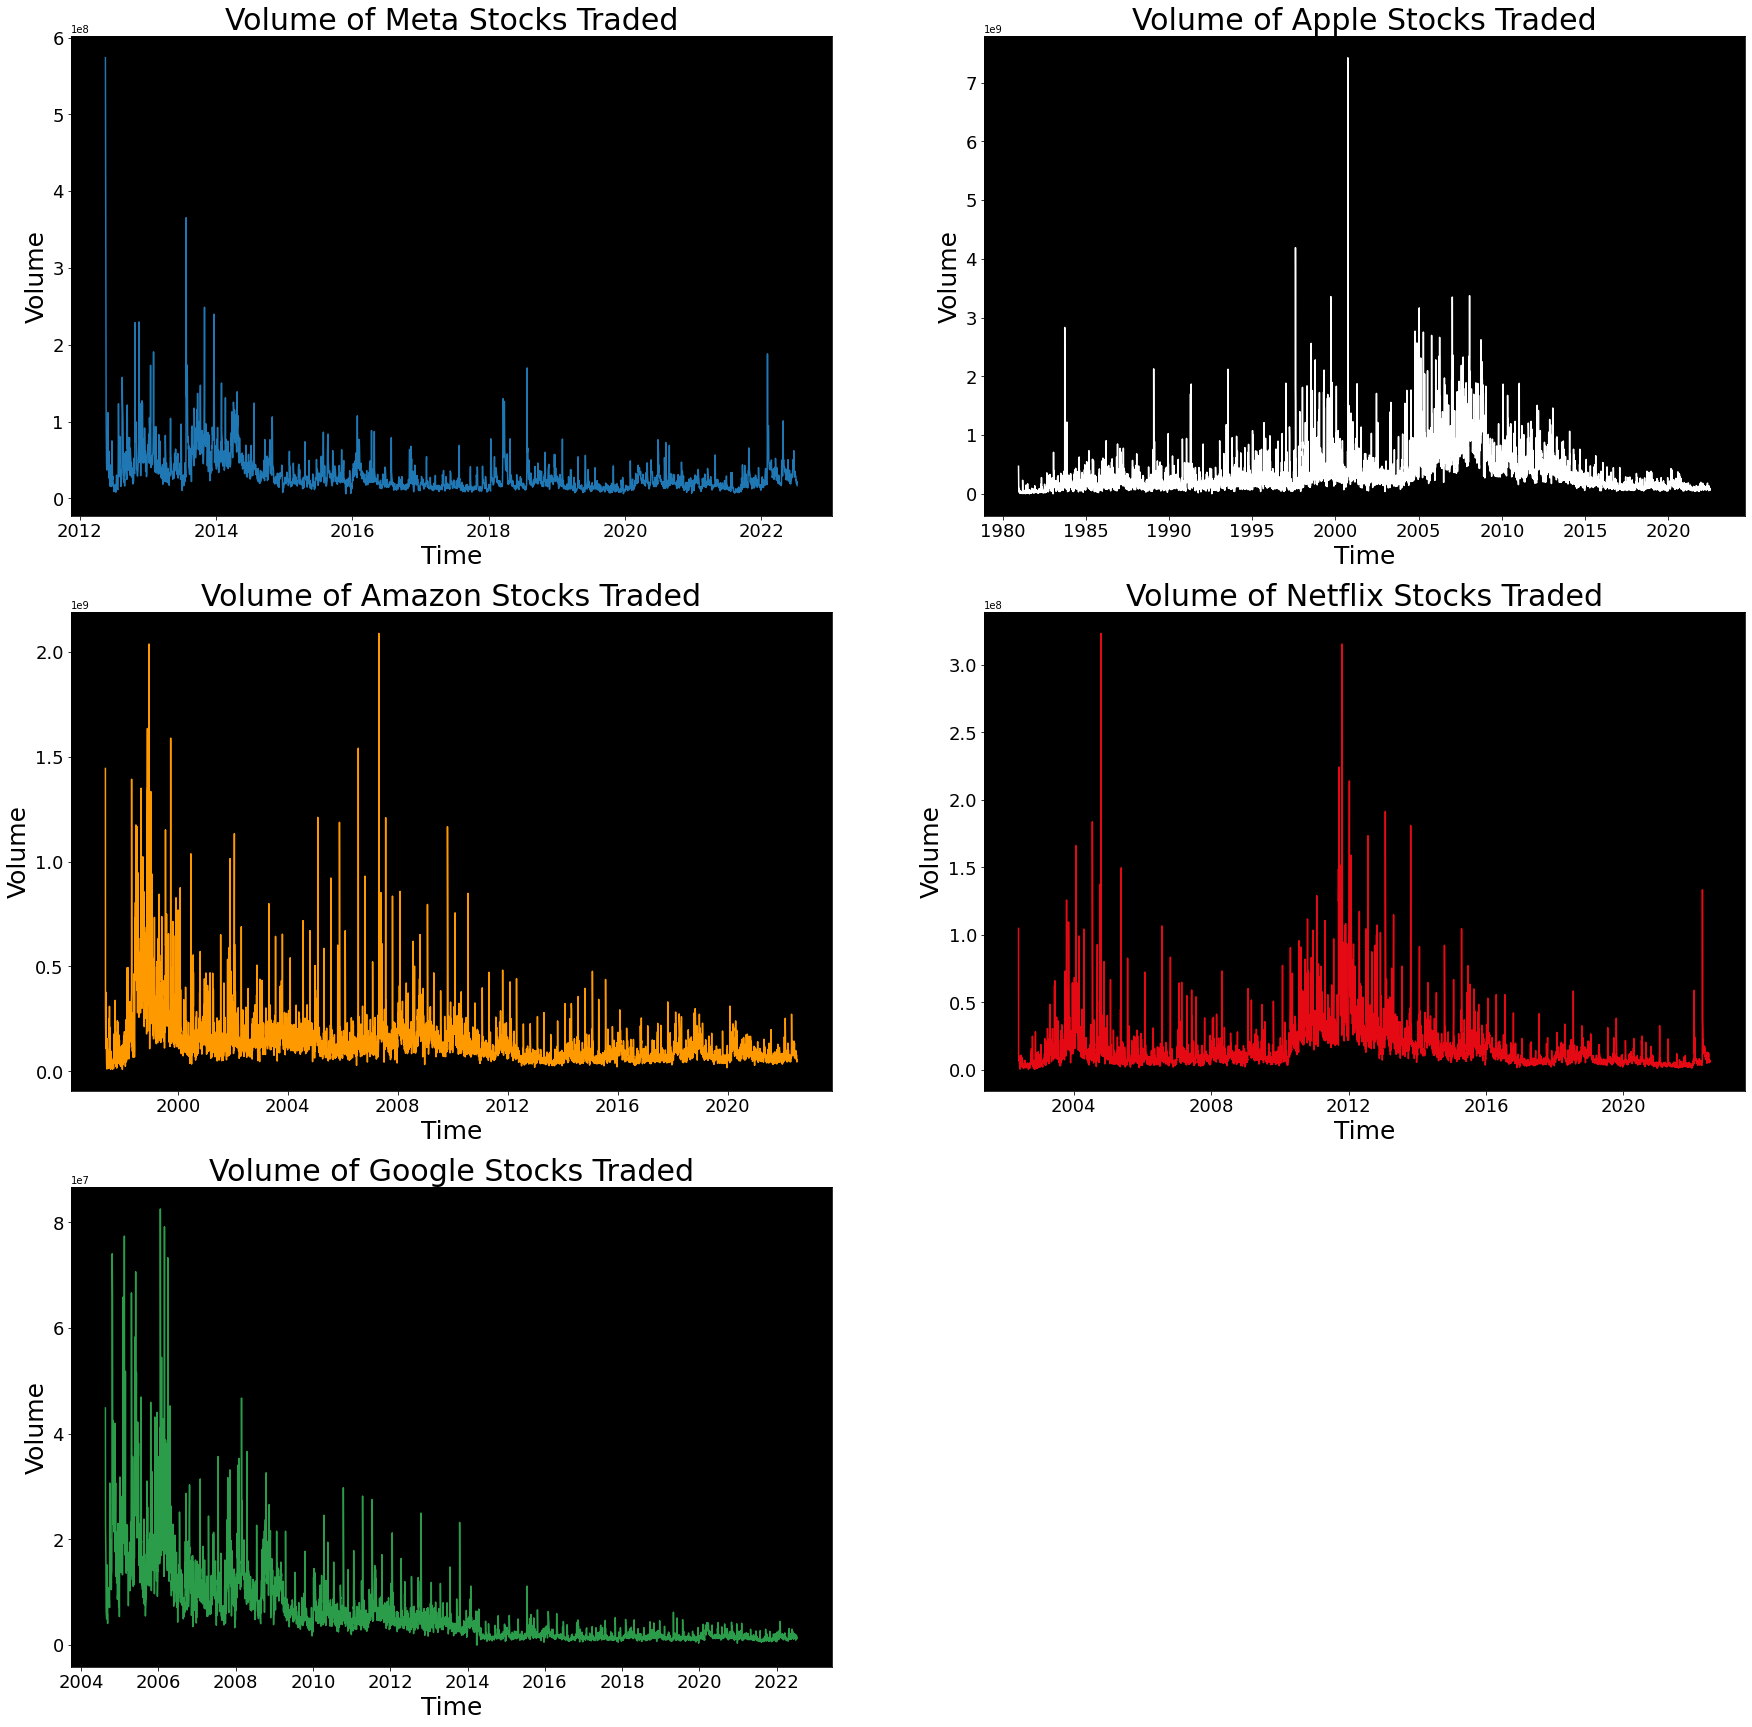

In [7]:
#Visualise the stock volume for FAANG
def visualize_faang_stock_volume(df_meta, df_aapl, df_amzn, df_nflx, df_goog):

    fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    axes[2][1].set_visible(False)
# Meta
    axes[0][0].set_facecolor('black')
    axes[0][0].plot(df_meta['Date'], df_meta['Volume'])
    axes[0][0].set_title("Volume of Meta Stocks Traded", fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Volume', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
# Apple    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(df_aapl['Date'], df_aapl['Volume'], color = 'white')
    axes[0][1].set_title("Volume of Apple Stocks Traded", fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Volume', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
# Amazon
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(df_amzn['Date'], df_amzn['Volume'], color = '#FF9900')
    axes[1][0].set_title("Volume of Amazon Stocks Traded", fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Volume', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
# Netflix
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(df_nflx['Date'], df_nflx['Volume'], color = '#E50913')
    axes[1][1].set_title("Volume of Netflix Stocks Traded", fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Volume', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
# Google
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(df_goog['Date'], df_goog['Volume'], color = '#2B9D4A')
    axes[2][0].set_title("Volume of Google Stocks Traded", fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Volume', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)

    plt.show()
    
visualize_faang_stock_volume(df_meta, df_aapl, df_amzn, df_nflx, df_goog)

**Observations**: Volume of a stock measures the number of shares traded for that stock.There is no particularly observable trend when it comes to the volume of the stock. For some companies such as **Meta** and **Google** we can observe that the volume of the stock being traded when the company was listed is higher than the volume being traded at present. This is because of the increase in the stock price over time. 

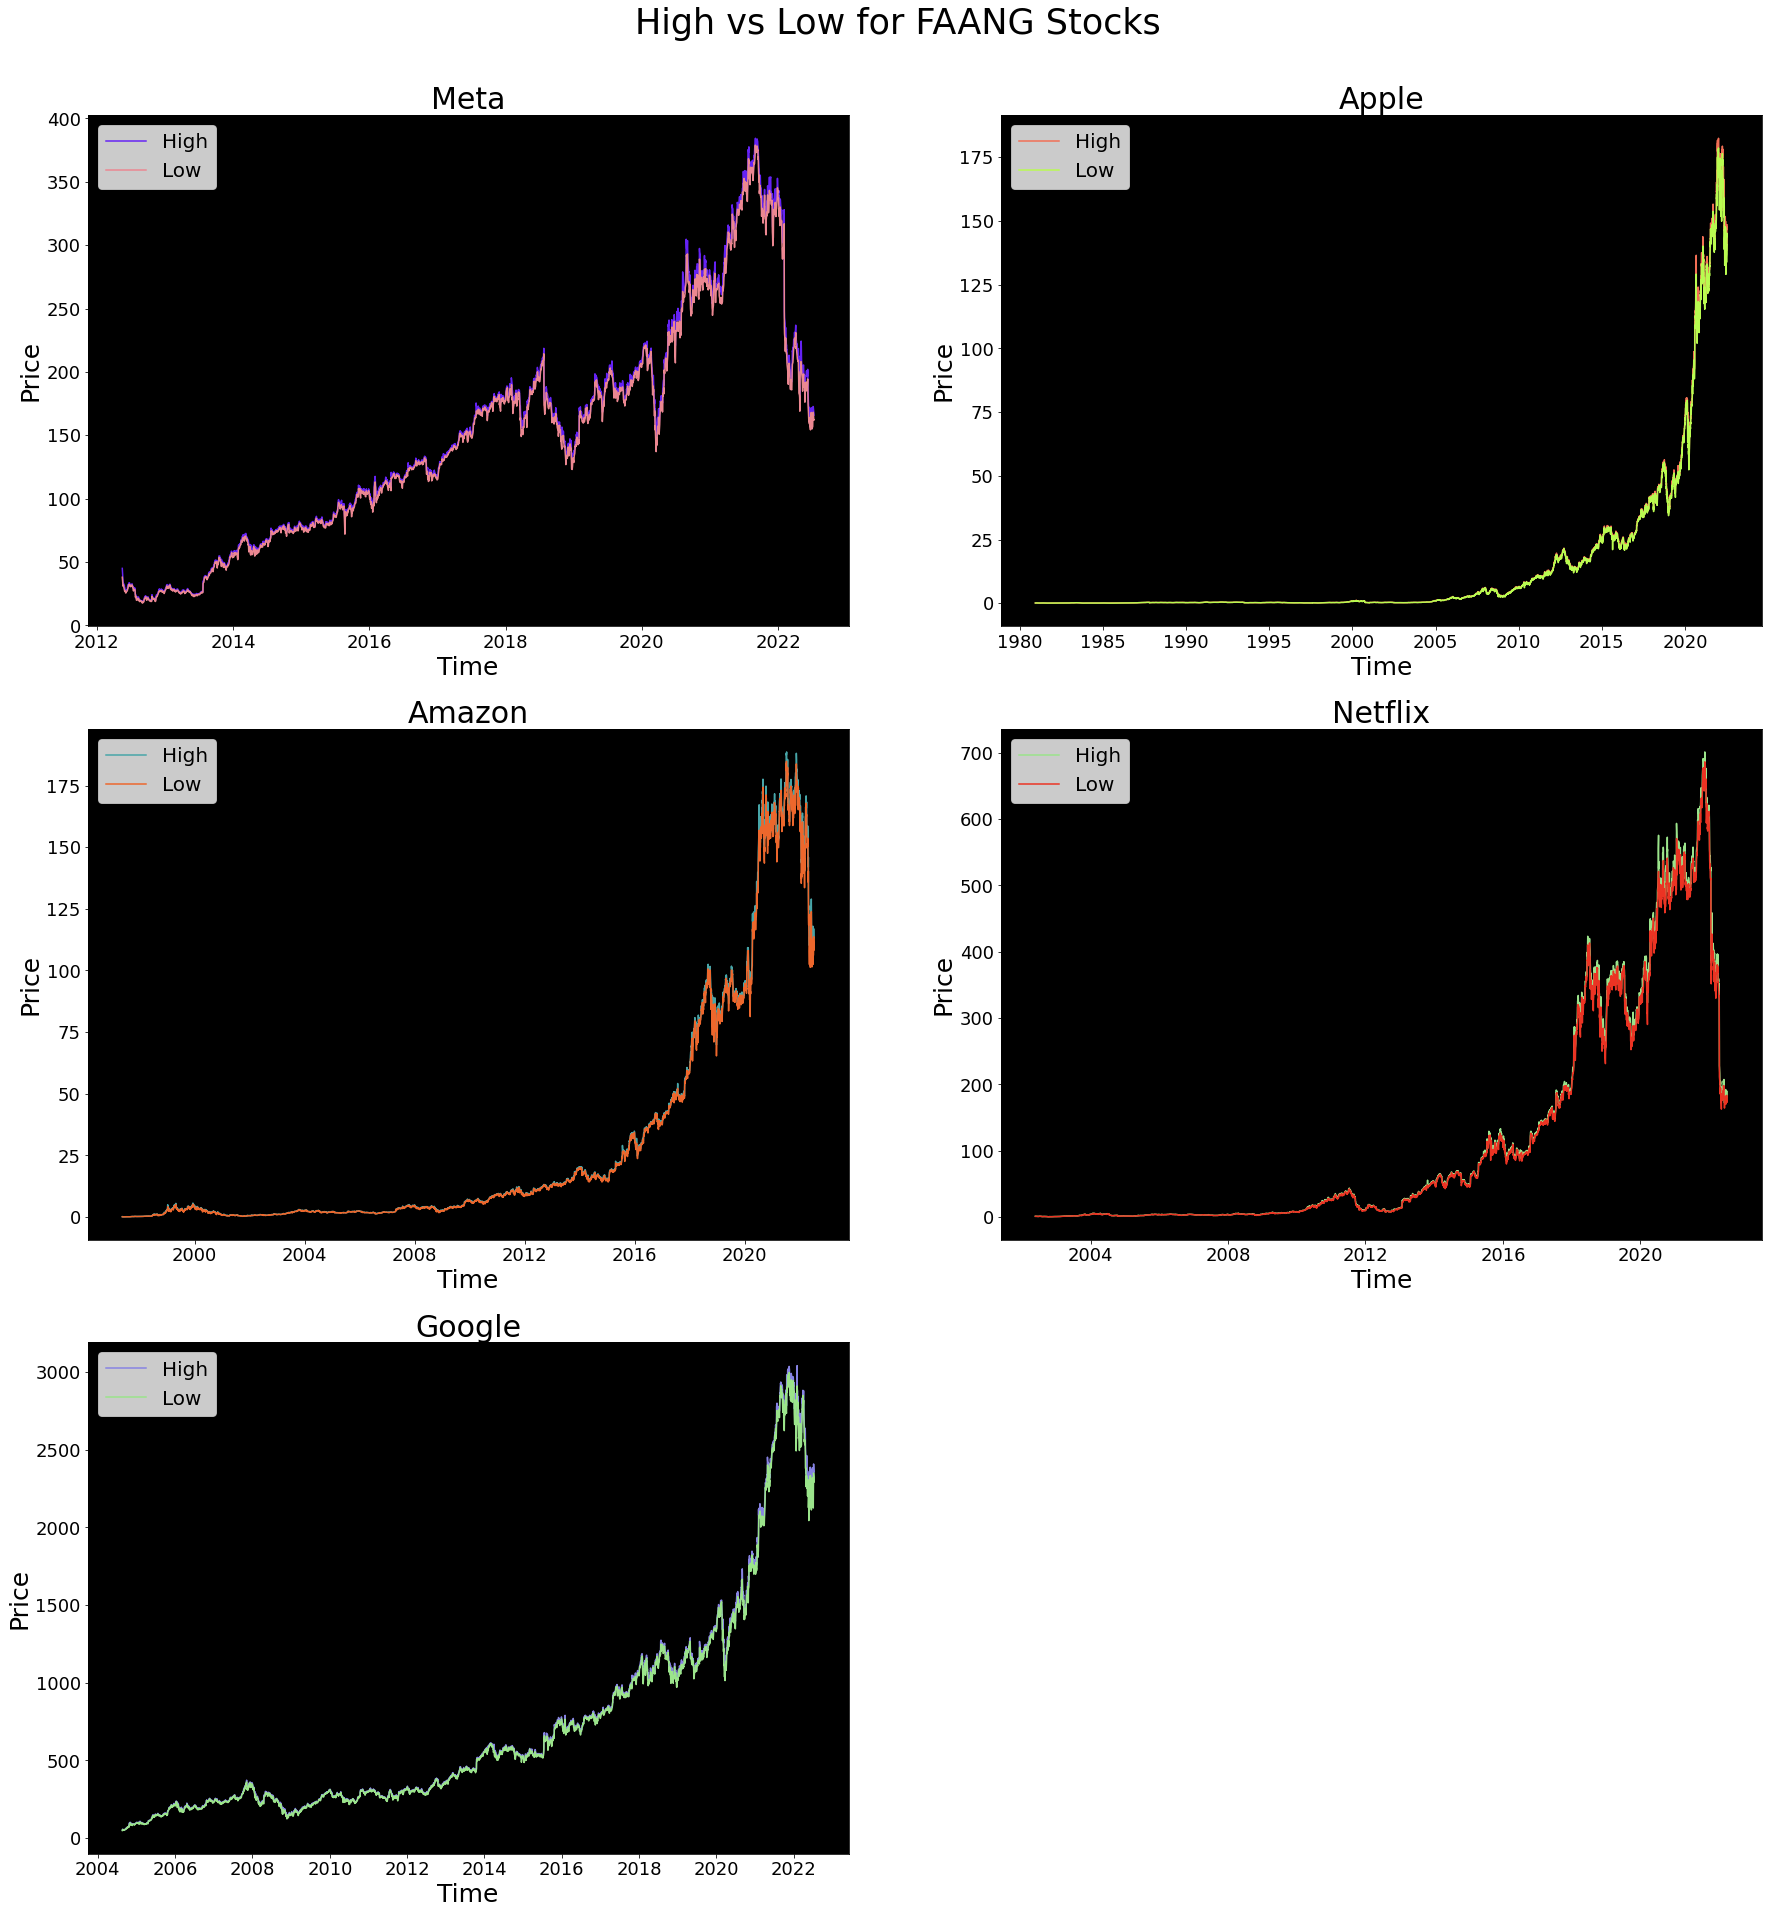

In [8]:
#Visualising the stock price high vs low for FAANG
def visualize_faang_two_features_over_time_graph(df_meta, df_aapl, df_amzn, df_nflx, df_goog, time, feature1, feature2):
    
    fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    axes[2][1].set_visible(False)
    
    plt.suptitle(feature1 + ' vs ' + feature2 + ' for FAANG Stocks', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
# Meta
    axes[0][0].set_facecolor('black')
    axes[0][0].plot(df_meta[time], df_meta[feature1], color = '#6522F5', label = feature1)
    axes[0][0].plot(df_meta[time], df_meta[feature2], color = '#EB8791', label = feature2)
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 20)
# Apple    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(df_aapl[time], df_aapl[feature1], color = '#F26E55', label = feature1)
    axes[0][1].plot(df_aapl[time], df_aapl[feature2], color = '#B9FB50', label = feature2)
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 20)
# Amazon    
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(df_amzn[time], df_amzn[feature1], color = '#47A5A8', label = feature1)
    axes[1][0].plot(df_amzn[time], df_amzn[feature2], color = '#ED672C', label = feature2)
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 20)
# Netflix    
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(df_nflx[time], df_nflx[feature1], color = '#9BE48B', label = feature1)
    axes[1][1].plot(df_nflx[time], df_nflx[feature2], color = '#EB3323', label = feature2)
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 20)
# Google    
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(df_goog[time], df_goog[feature1], color = '#8783E3', label = feature1)
    axes[2][0].plot(df_goog[time], df_goog[feature2], color = '#9BE48B', label = feature2)
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 20)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
visualize_faang_two_features_over_time_graph(df_meta, df_aapl, df_amzn, df_nflx, df_goog, 'Date', 'High', 'Low')

**Observations**: The high is the highest price at which a stock is traded during a period. The low is the lowest price of that same period. A stock's high and low points for the day are often called its intraday high and low. The **High** and **Low** of the stocks almost overlap each other, indicating that the range of Highs and Lows for the day was about the same. There are a few exceptions with an increasingly large value of **`High`** as compared to the **`Low`**. These could be indicators of a bullish market.

In [9]:
#Subset the data into the below columns 
candlestick_chart_data = ['Date', 'Open', 'High', 'Low', 'Close']
new_meta_df = df_meta[candlestick_chart_data]
new_aapl_df = df_aapl[candlestick_chart_data]
new_amzn_df = df_amzn[candlestick_chart_data]
new_nflx_df = df_nflx[candlestick_chart_data]
new_goog_df = df_goog[candlestick_chart_data]

# Function to create moving average of 10,50 and 100 days
def create_moving_averages_columns(company_data):
    days_for_moving_averages = [10, 50, 100]
    
    for moving_averages in days_for_moving_averages:
        column = f'MA for {moving_averages} days'
        company_data[column] = company_data['Close'].rolling(moving_averages).mean()
        
    return company_data
#Save the moving average into a new dataframe
new_meta_df = create_moving_averages_columns(new_meta_df)
new_aapl_df = create_moving_averages_columns(new_aapl_df)
new_amzn_df = create_moving_averages_columns(new_amzn_df)
new_nflx_df = create_moving_averages_columns(new_nflx_df)
new_goog_df = create_moving_averages_columns(new_goog_df)

#Print the last 5 values for Meta dataframe
new_meta_df.tail(10)

Date        Open        High         Low       Close  \
2543 2022-06-28  169.899994  171.300003  160.610001  160.679993   
2544 2022-06-29  163.570007  166.330002  160.320007  163.940002   
2545 2022-06-30  162.149994  165.229996  158.490005  161.250000   
2546 2022-07-01  160.309998  160.619995  155.000000  160.029999   
2547 2022-07-05  158.139999  168.250000  157.020004  168.190002   
2548 2022-07-06  168.199997  171.589996  165.460007  169.770004   
2549 2022-07-07  169.449997  172.720001  167.779999  172.190002   
2550 2022-07-08  169.979996  172.399994  168.149994  170.880005   
2551 2022-07-11  167.070007  167.490005  161.910004  162.880005   
2552 2022-07-12  164.800003  165.910004  162.100006  163.270004   

      MA for 10 days  MA for 50 days  MA for 100 days  
2543      162.967001      188.412800       201.008601  
2544      162.988002      187.476200       200.270401  
2545      162.178001      186.355000       199.512001  
2546      162.094002      185.547200       198.863201  
2547      162.539001      185.149600       198.343301  
2548      163.811002      184.862800       197.721001  
2549      165.445001      184.566800       197.162201  
2550      166.658002      184.365400       196.675501  
2551      165.930002      184.124001       196.127301  
2552      165.308002      183.274801       195.550001

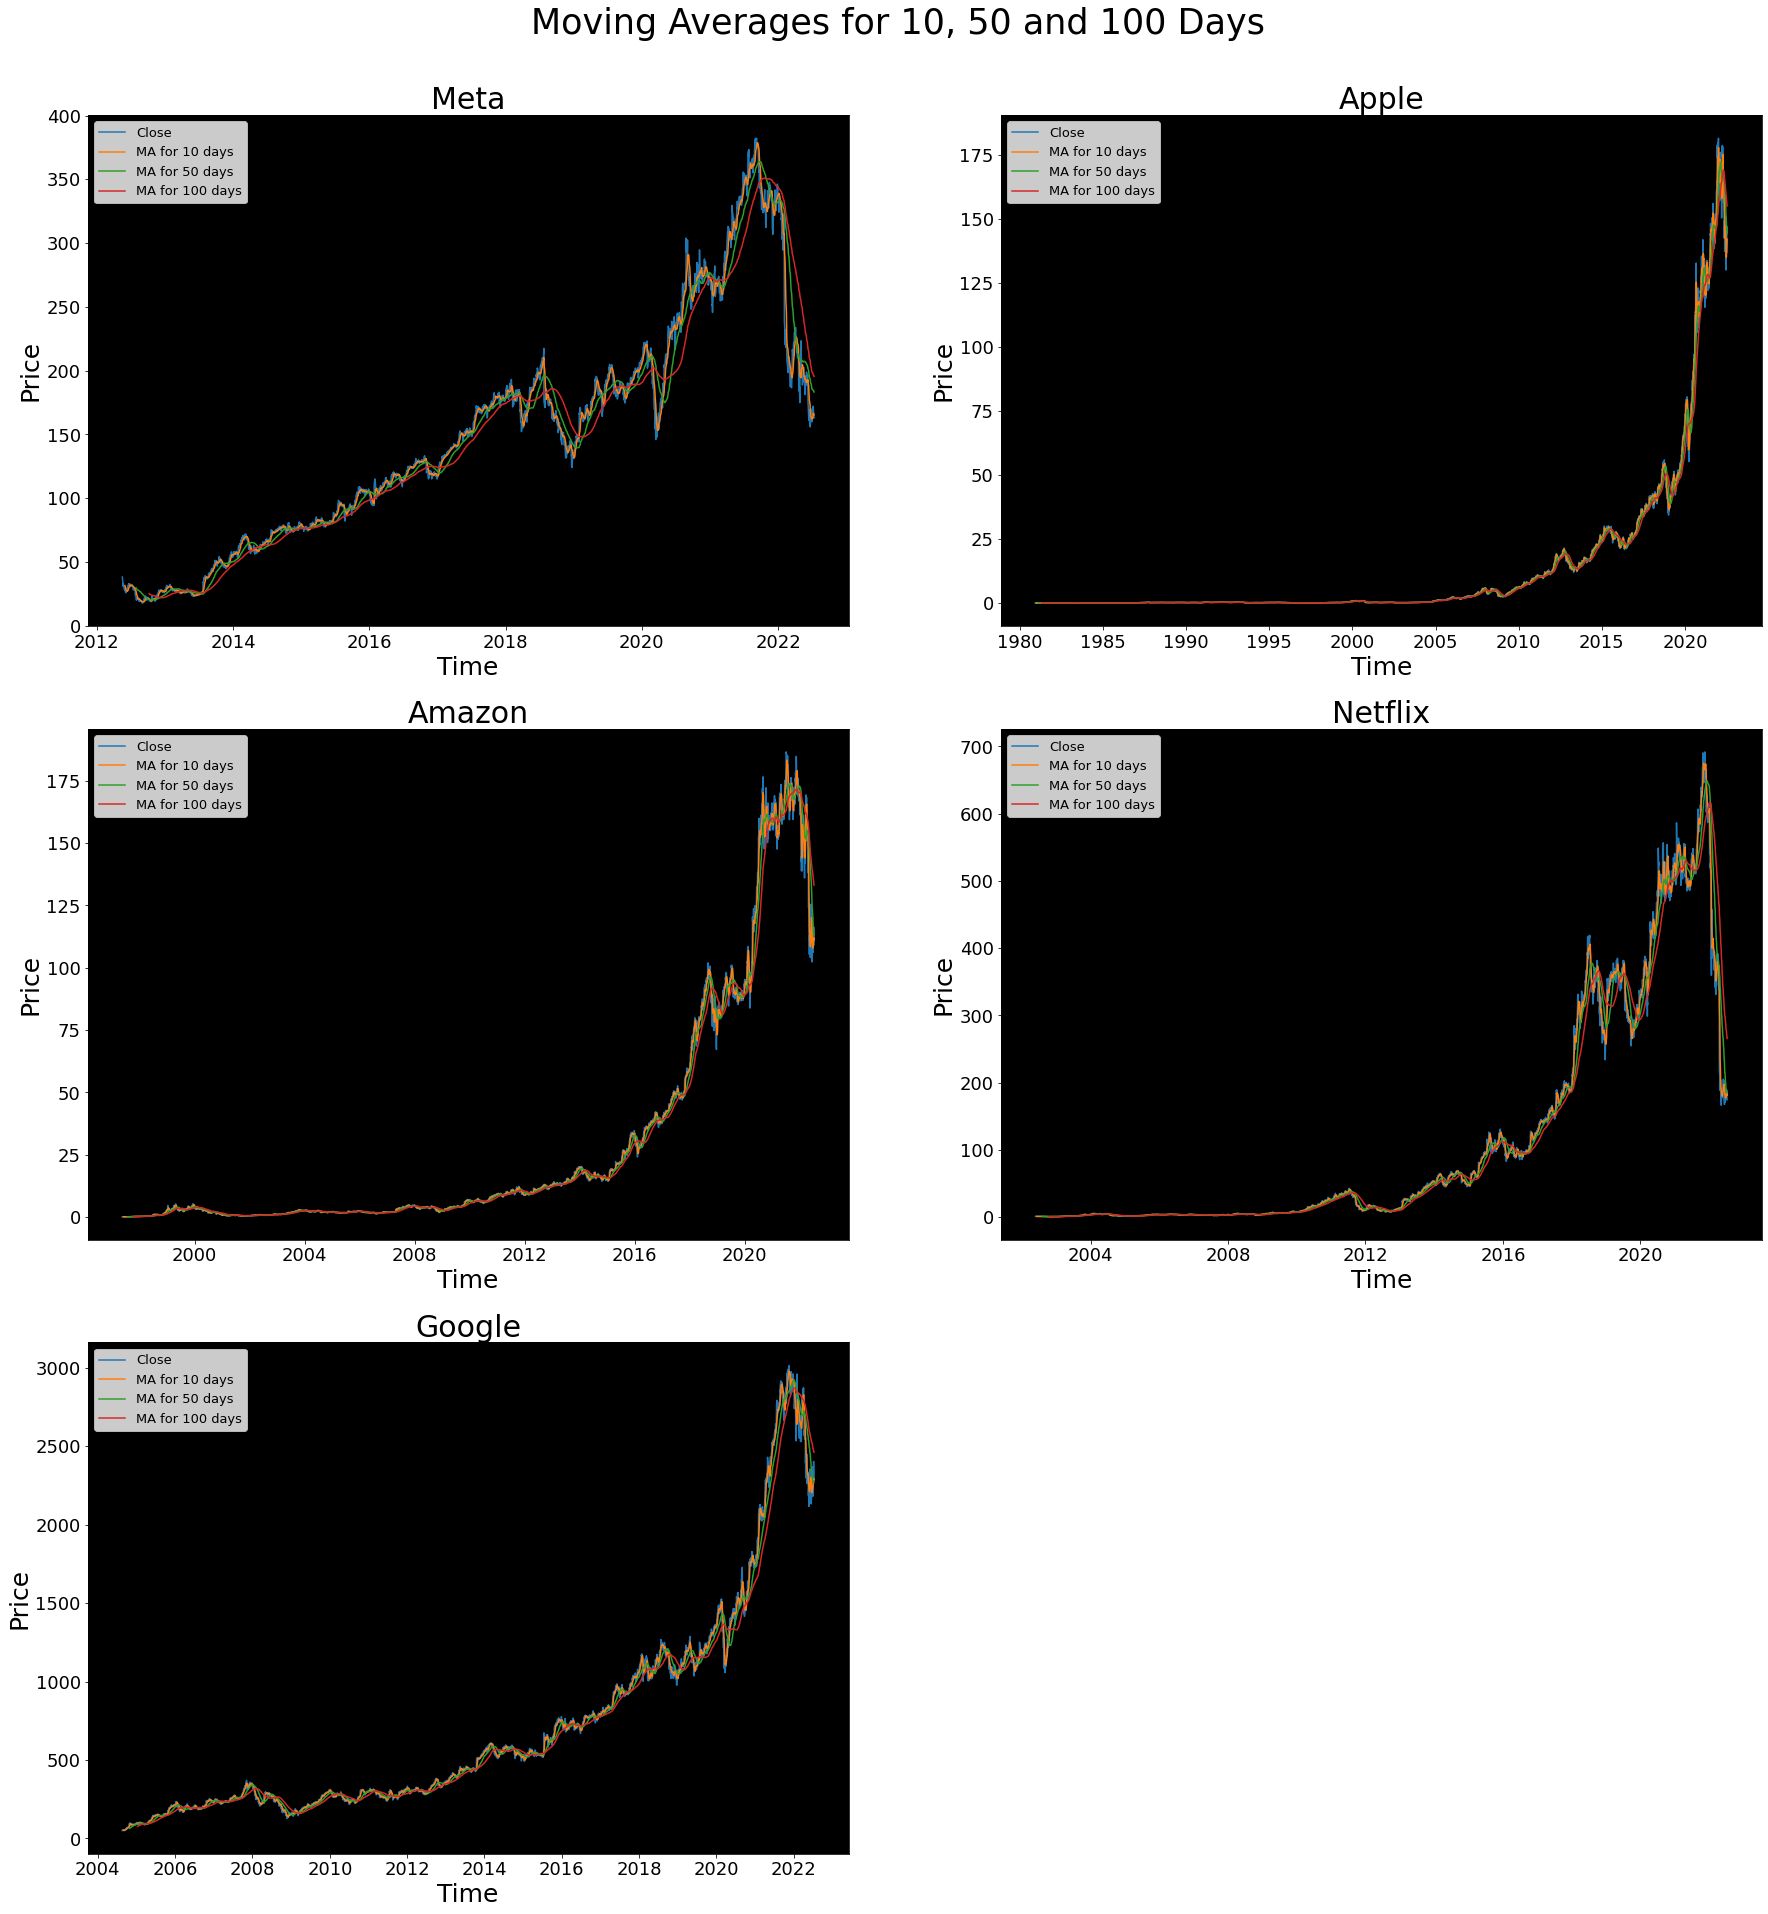

In [10]:
#Visualise the moving averages
def visualize_moving_averages(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, time, feature, ma1, ma2, ma3):

    fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    axes[2][1].set_visible(False)

    plt.suptitle('Moving Averages for 10, 50 and 100 Days', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
# Meta
    axes[0][0].set_facecolor('black')
    axes[0][0].plot(new_meta_df[time], new_meta_df[feature], label = feature)
    axes[0][0].plot(new_meta_df[time], new_meta_df[ma1], label = ma1)
    axes[0][0].plot(new_meta_df[time], new_meta_df[ma2], label = ma2)
    axes[0][0].plot(new_meta_df[time], new_meta_df[ma3], label = ma3)
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 13)
# Apple    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[feature], label = feature)
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[ma1], label = ma1)
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[ma2], label = ma2)
    axes[0][1].plot(new_aapl_df[time], new_aapl_df[ma3], label = ma3)
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 13)
# Amazon    
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[feature], label = feature)
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[ma1], label = ma1)
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[ma2], label = ma2)
    axes[1][0].plot(new_amzn_df[time], new_amzn_df[ma3], label = ma3)
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 13)
# Netflix    
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[feature], label = feature)
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[ma1], label = ma1)
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[ma2], label = ma2)
    axes[1][1].plot(new_nflx_df[time], new_nflx_df[ma3], label = ma3)
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 13)
# Google    
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(new_goog_df[time], new_goog_df[feature], label = feature)
    axes[2][0].plot(new_goog_df[time], new_goog_df[ma1], label = ma1)
    axes[2][0].plot(new_goog_df[time], new_goog_df[ma2], label = ma2)
    axes[2][0].plot(new_goog_df[time], new_goog_df[ma3], label = ma3)
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 13)
# Plot
    plt.subplots_adjust(top = 0.93)
    plt.show()

visualize_moving_averages(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, 'Date', 'Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days')

**Observations**: **Moving Averages (MA)** are one of the most popular and often used technical indicators in financial markets. In simple word, a moving average is an indicator that shows the average value of a stock's price over a period (i.e. 10 days, 50 days, 100 days, etc) and is usually plotted along with the closing price. The most common applications of moving averages are to **identify the trending direction** and determine support and resistance levels. One can also say that moving averages are used to smoothen out the **noise** of short-term price fluctuations, so as to be able to identify and define significant underlying trends more readily. When calculating a moving average, a mathematical analysis of the stock's average value over a predetermined time period is made. As the stock price changes, its average price moves up or down.

In [11]:
# Create new column called 'Daily Return' for % change in daily stock price
new_meta_df['Daily Return'] = new_meta_df['Close'].pct_change()
new_aapl_df['Daily Return'] = new_aapl_df['Close'].pct_change()
new_amzn_df['Daily Return'] = new_amzn_df['Close'].pct_change()
new_nflx_df['Daily Return'] = new_nflx_df['Close'].pct_change()
new_goog_df['Daily Return'] = new_goog_df['Close'].pct_change()
new_meta_df.tail()

Date        Open        High         Low       Close  \
2548 2022-07-06  168.199997  171.589996  165.460007  169.770004   
2549 2022-07-07  169.449997  172.720001  167.779999  172.190002   
2550 2022-07-08  169.979996  172.399994  168.149994  170.880005   
2551 2022-07-11  167.070007  167.490005  161.910004  162.880005   
2552 2022-07-12  164.800003  165.910004  162.100006  163.270004   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
2548      163.811002      184.862800       197.721001      0.009394  
2549      165.445001      184.566800       197.162201      0.014255  
2550      166.658002      184.365400       196.675501     -0.007608  
2551      165.930002      184.124001       196.127301     -0.046816  
2552      165.308002      183.274801       195.550001      0.002394

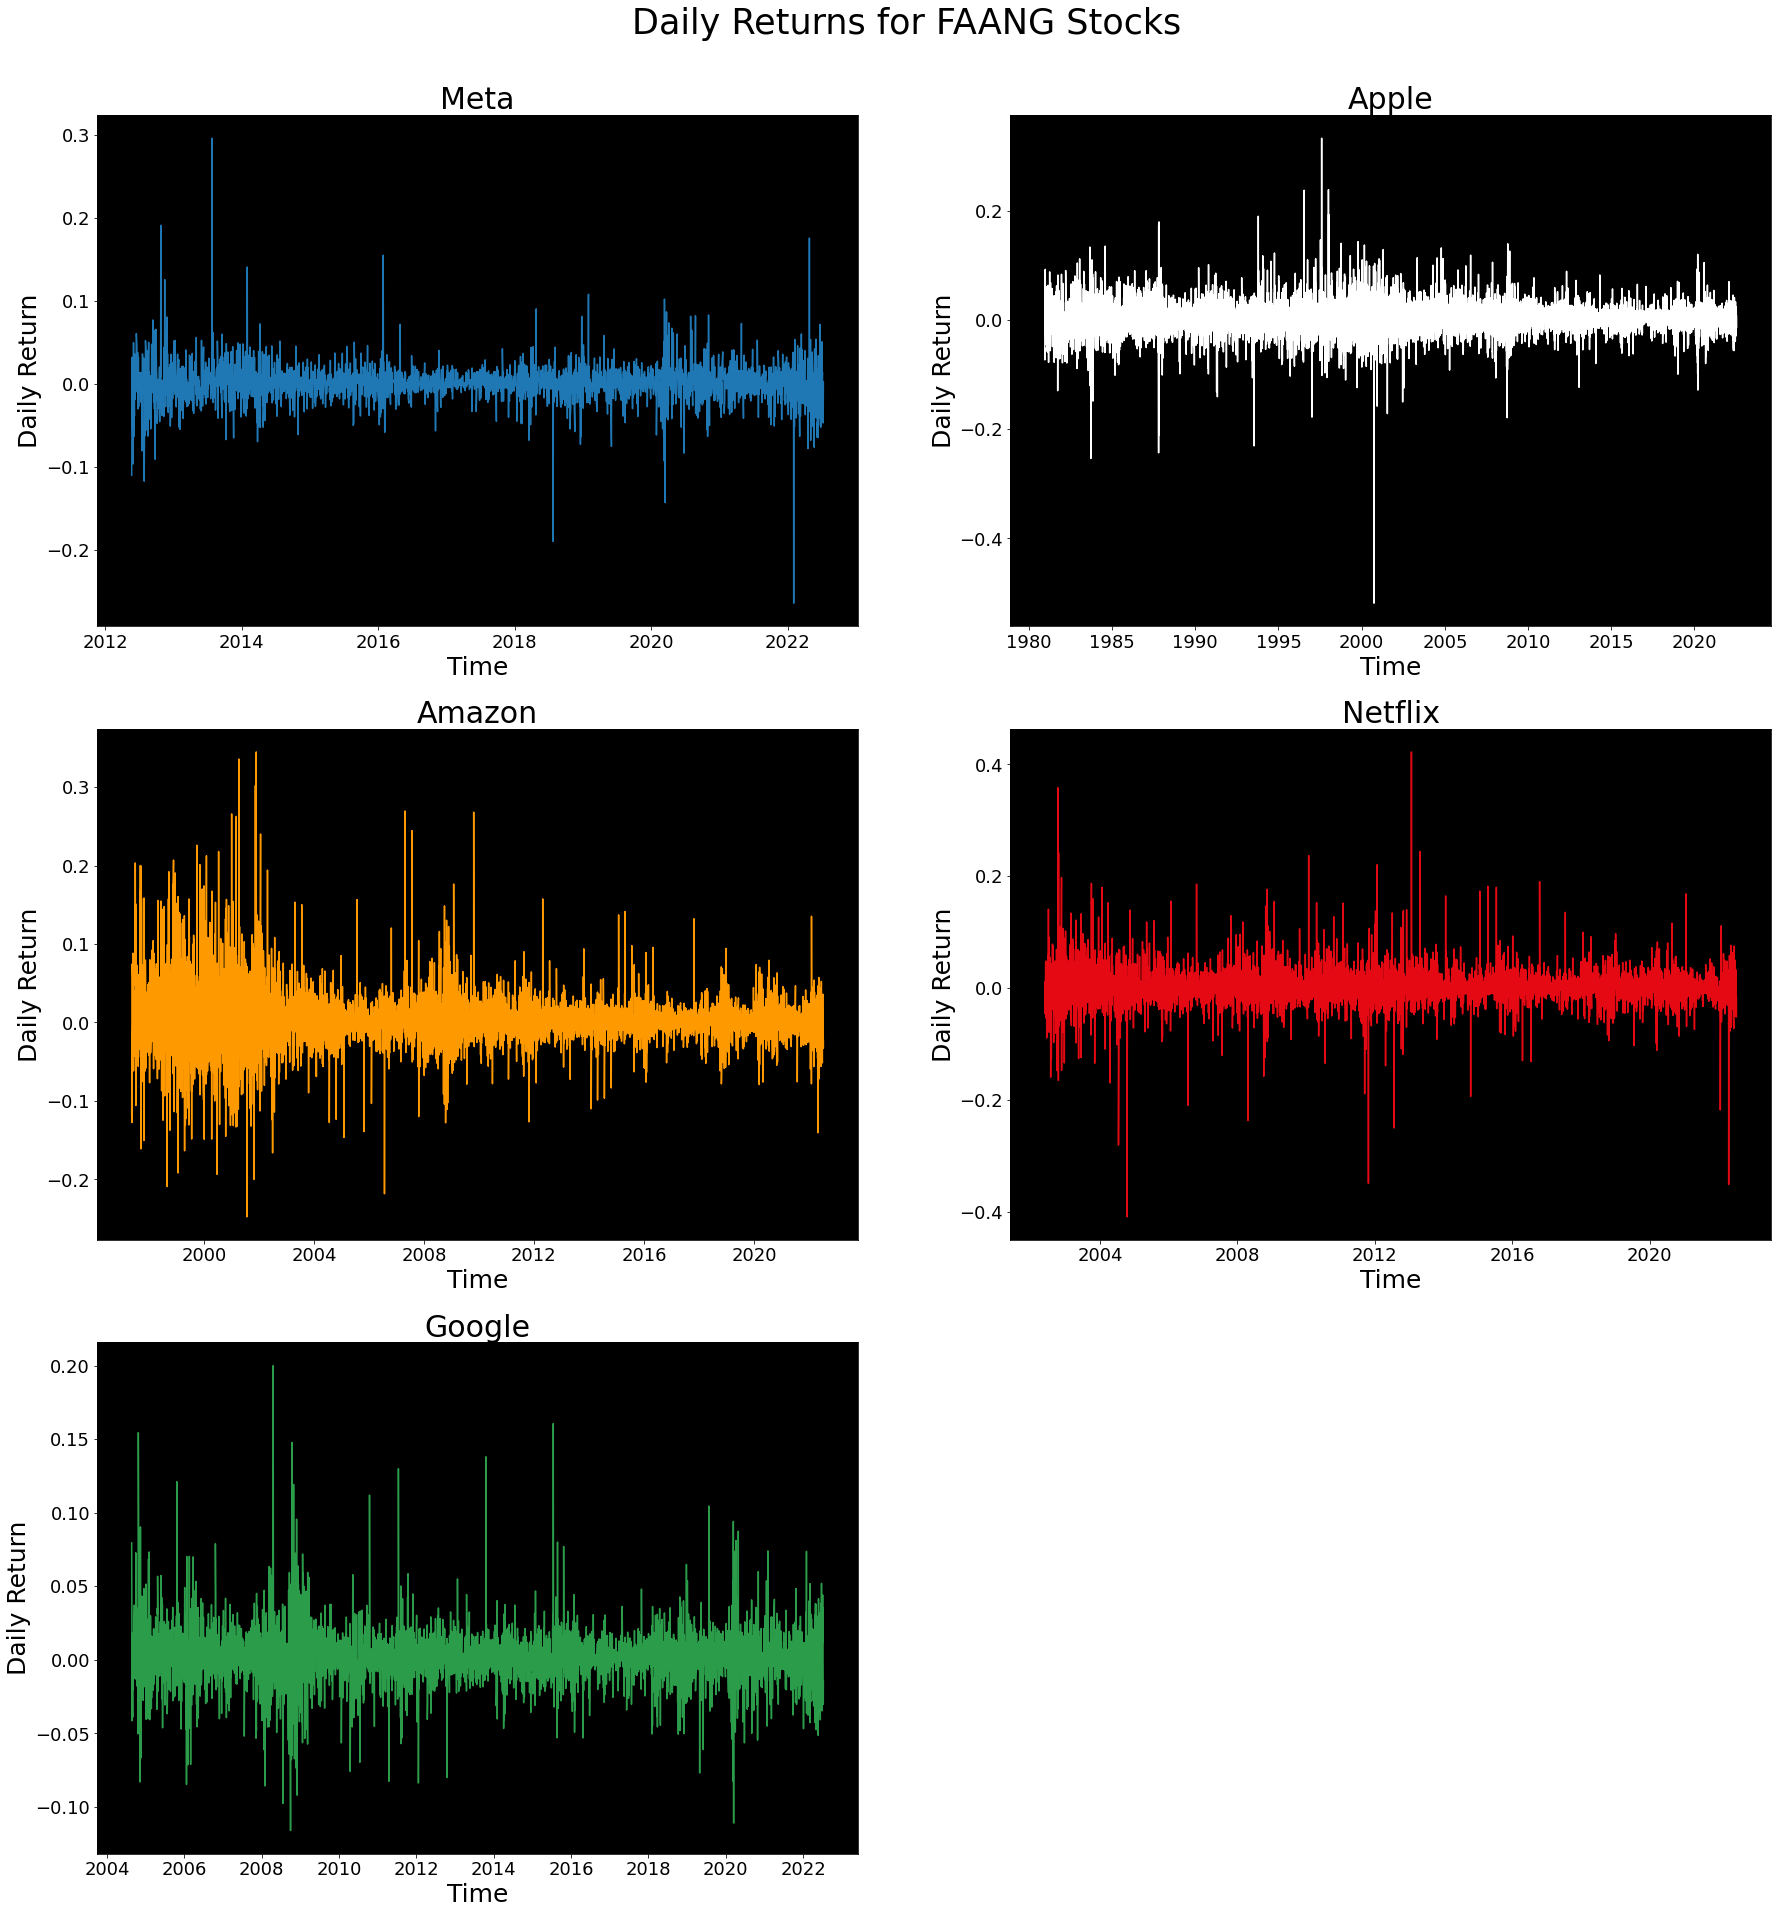

In [12]:
#Visualise the %change in daily stock price 
def visualize_faang_daily_return(df_meta, df_aapl, df_amzn, df_nflx, df_goog):

    fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    axes[2][1].set_visible(False)
    
    plt.suptitle('Daily Returns for FAANG Stocks', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
# Meta
    axes[0][0].set_facecolor('black')
    axes[0][0].plot(df_meta['Date'], df_meta['Daily Return'])
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Daily Return', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
# Apple    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(df_aapl['Date'], df_aapl['Daily Return'], color = 'white')
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Daily Return', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
# Amazon
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(df_amzn['Date'], df_amzn['Daily Return'], color = '#FF9900')
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Daily Return', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
# Netflix
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(df_nflx['Date'], df_nflx['Daily Return'], color = '#E50913')
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Daily Return', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
# Google
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(df_goog['Date'], df_goog['Daily Return'], color = '#2B9D4A')
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Daily Return', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
# Plot    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
visualize_faang_daily_return(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df)

**Observations**: Daily return on a stock is used to measure the **day to day performance** of stocks, it is the price of stocks at today’s close compared to the price of the same stock at yesterday’s close. A positive daily return means appreciation in stock price for that particular day. Based on the graphs we plotted for the daily return over time for FAANG stocks, *no particular pattern or trend can be observed*. All the graphs contain a **large number of fluctuations** in the data, making it difficult to identify any specific trend in the movement of the stock.

# Predictions Using LSTM
LSTM stands for **Long Short Term Memory**. It is a type of ***Recurrent Neural Network*** that is capable of learning long-term dependencies, especially in sequence prediction problems. LSTMs have **feedback connections** which make them different to more traditional feedforward neural networks. This property enables LSTMs to process entire sequences of data (e.g. time series) without treating each point in the sequence independently, but rather, retaining useful information about previous data in the sequence to help with the processing of new data points.

The output of an LSTM at a particular point in time is dependant on 3 things:
> - The current long-term memory of the network, known as the **cell state**
> - The output at the previous point in time, known as the **previous hidden state**
> - The **input data** at the current time step

LSTMs use a series of **gates** which control how the information in a sequence of data comes into, is stored in and leaves the network. There are 3 gates in a typical LSTM:
> - Forget Gate 
> - Input Gate
> - Output Gate

These gates can be thought of as filters and are each their own neural network. This is what the visual representation of an LSTM looks like:

<img src = "http://bit.ly/2i3kb1w" width = 50%>
<br>

In [13]:
# Retrieve the closing prices
def retrieve_closing_prices_only(data):
    data = data[['Close']]
    return data

# Normalize the data using MinMaxScaler
def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range = (0, 1))
    data = scaler.fit_transform(data.values)
    return scaler, data

# Save them in a new dataframe    
meta_scaler, new_meta_df = min_max_scaling(retrieve_closing_prices_only(new_meta_df))
aapl_scaler, new_aapl_df = min_max_scaling(retrieve_closing_prices_only(new_aapl_df))
amzn_scaler, new_amzn_df = min_max_scaling(retrieve_closing_prices_only(new_amzn_df))
nflx_scaler, new_nflx_df = min_max_scaling(retrieve_closing_prices_only(new_nflx_df))
goog_scaler, new_goog_df = min_max_scaling(retrieve_closing_prices_only(new_goog_df))

new_meta_df

array([[0.05624914],
       [0.04472493],
       [0.03641103],
       ...,
       [0.42022228],
       [0.39827139],
       [0.39934149]])

In [14]:
#Splitting and Reshaping the data
def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
# Training size 95%, Test size 5%
    train_size = int(np.ceil(len(dataframe) * 0.95))
    test_size = len(dataframe) - train_size
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    train_data = dataframe[0: int(train_size), :]
    test_data = dataframe[train_size - prediction_days:, :]

# X is independent variable, y is dependent variable  
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i, 0])
        y_train.append(train_data[i, 0])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i, 0])
        y_test.append(test_data[i, 0])
# Reshaping the data        
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
        
    print('Data for {} split successfully'.format(company.title()))
    
    return X_train, y_train, X_test, y_test

# Save the data in a new dataframe
X_train_meta, y_train_meta, X_test_meta, y_test_meta = split_and_reshape_data(new_meta_df, 30, 'META')
X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl = split_and_reshape_data(new_aapl_df, 30, 'APPLE')
X_train_amzn, y_train_amzn, X_test_amzn, y_test_amzn = split_and_reshape_data(new_amzn_df, 30, 'AMAZON')
X_train_nflx, y_train_nflx, X_test_nflx, y_test_nflx = split_and_reshape_data(new_nflx_df, 30, 'NETFLIX')
X_train_goog, y_train_goog, X_test_goog, y_test_goog = split_and_reshape_data(new_goog_df, 30, 'GOOGLE')

The training size for Meta is 2426 rows
The testing size for Meta is 127 rows
Data for Meta split successfully
The training size for Apple is 9959 rows
The testing size for Apple is 524 rows
Data for Apple split successfully
The training size for Amazon is 6015 rows
The testing size for Amazon is 316 rows
Data for Amazon split successfully
The training size for Netflix is 4816 rows
The testing size for Netflix is 253 rows
Data for Netflix split successfully
The training size for Google is 4280 rows
The testing size for Google is 225 rows
Data for Google split successfully


In [15]:
# Creating and training an LSTM model
def create_and_train_lstm_model(X_train, y_train, X_test, y_test, company):
    print(f'=========For {company}=========')

# Define the layers of the neural network
    model = Sequential([
        Conv1D(32, 3, strides=1, activation='relu', input_shape=[30, 1]),
        LSTM(64, return_sequences=True),
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(1)
    ])
# Compile and Fit the LSTM model    
    model.compile(optimizer=Adam(), loss=Huber(), metrics=['mse', 'mae'])
# Add an early stopping method to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Fitting the model    
    predictor = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping])
# Predicting on the test dataset    
    y_pred = model.predict(X_test)
    
    return model, predictor, y_pred
# Save it in a new dataframe
meta_model, meta_predictor, meta_y_pred = create_and_train_lstm_model(X_train_meta, y_train_meta, X_test_meta, y_test_meta, 'Meta')
aapl_model, aapl_predictor, aapl_y_pred = create_and_train_lstm_model(X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl, 'Apple')
amzn_model, amzn_predictor, amzn_y_pred = create_and_train_lstm_model(X_train_amzn, y_train_amzn, X_test_amzn, y_test_amzn, 'Amazon')
nflx_model, nflx_predictor, nflx_y_pred = create_and_train_lstm_model(X_train_nflx, y_train_nflx, X_test_nflx, y_test_nflx, 'Netflix')
goog_model, goog_predictor, goog_y_pred = create_and_train_lstm_model(X_train_goog, y_train_goog, X_test_goog, y_test_goog, 'Google')


=========For Meta=========
Epoch 1/50
75/75 [==============================] - 12s 20ms/step - loss: 0.0056 - mse: 0.0113 - mae: 0.0560 - val_loss: 0.0046 - val_mse: 0.0091 - val_mae: 0.0710
Epoch 2/50
75/75 [==============================] - 1s 8ms/step - loss: 3.1088e-04 - mse: 6.2177e-04 - mae: 0.0172 - val_loss: 0.0038 - val_mse: 0.0075 - val_mae: 0.0623
Epoch 3/50
75/75 [==============================] - 1s 7ms/step - loss: 2.8396e-04 - mse: 5.6791e-04 - mae: 0.0161 - val_loss: 0.0029 - val_mse: 0.0058 - val_mae: 0.0535
Epoch 4/50
75/75 [==============================] - 1s 8ms/step - loss: 2.9636e-04 - mse: 5.9273e-04 - mae: 0.0165 - val_loss: 0.0020 - val_mse: 0.0041 - val_mae: 0.0459
Epoch 5/50
75/75 [==============================] - 1s 7ms/step - loss: 3.1593e-04 - mse: 6.3186e-04 - mae: 0.0171 - val_loss: 0.0024 - val_mse: 0.0048 - val_mae: 0.0487
Epoch 6/50
75/75 [==============================] - 1s 7ms/step - loss: 3.4499e-04 - mse: 6.8998e-04 - mae: 0.0178 - val_loss: 0.

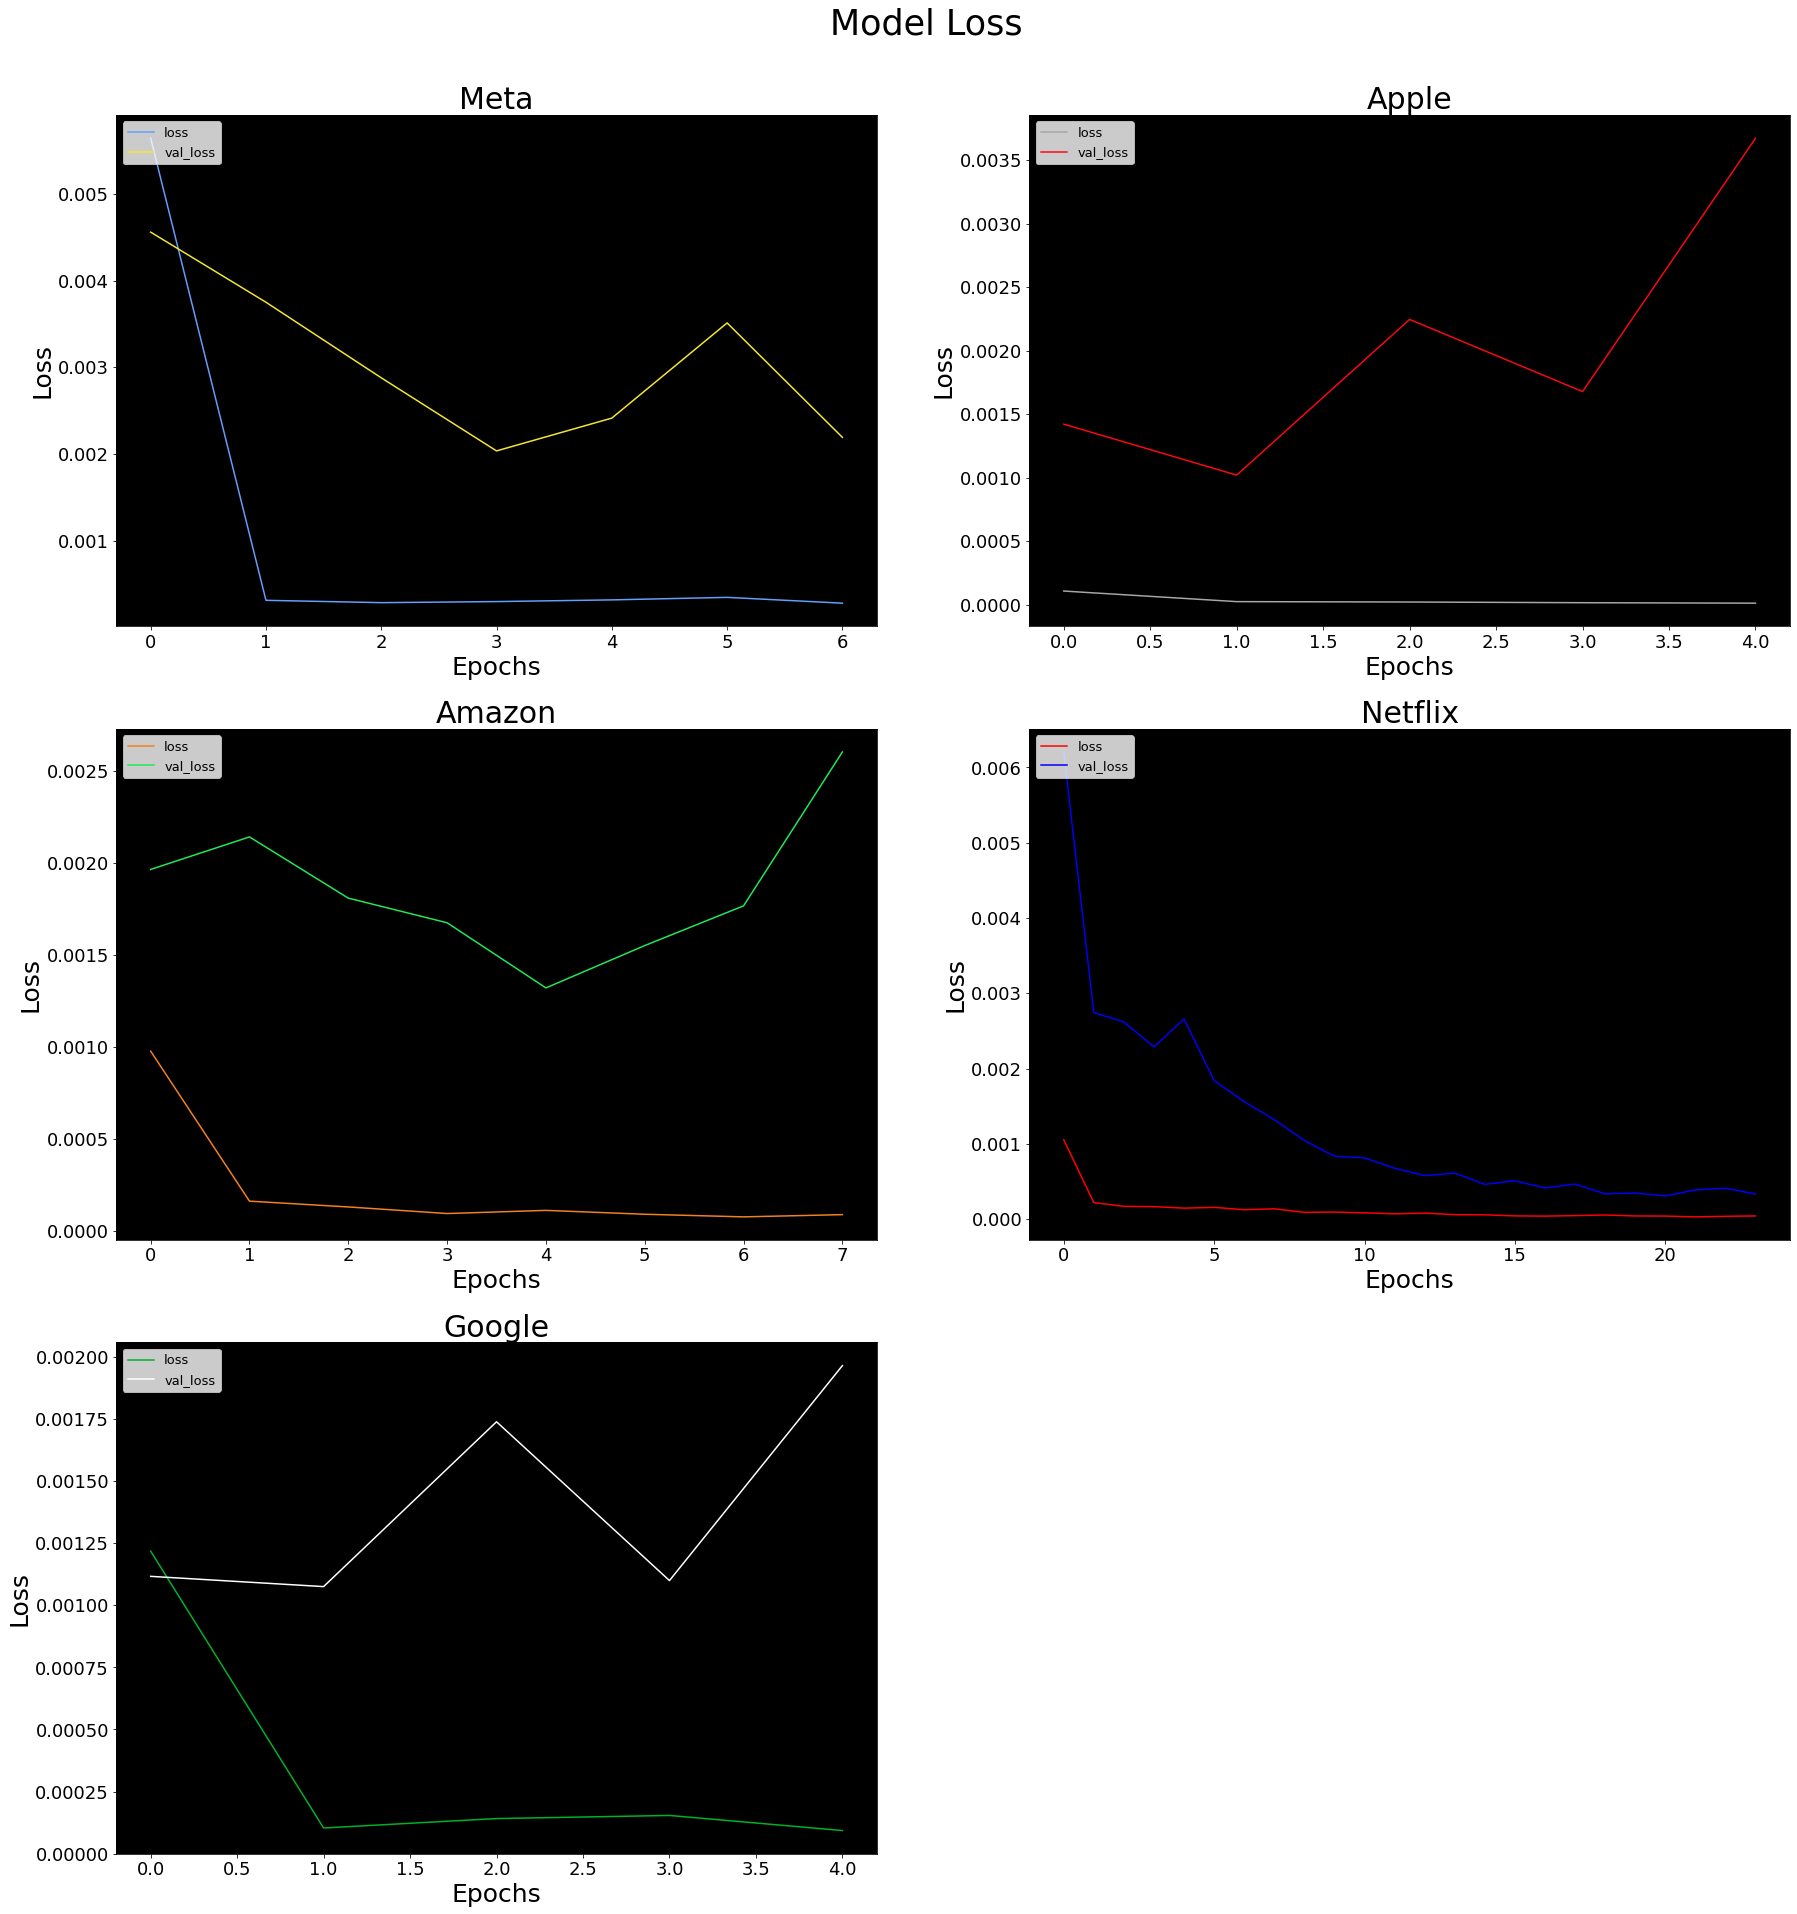

In [16]:
#Visualise the model loss
def visualize_model_loss(meta_predictor, aapl_predictor, amzn_predictor, nflx_predictor, goog_predictor):
    fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    axes[2][1].set_visible(False)
    
    plt.suptitle('Model Loss', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
# Meta
    axes[0][0].set_facecolor('black')
    axes[0][0].plot(meta_predictor.epoch, meta_predictor.history['loss'], label = 'loss', color = '#649EFF')
    axes[0][0].plot(meta_predictor.epoch, meta_predictor.history['val_loss'], label = 'val_loss', color = '#F5E633')
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Epochs', fontsize = 25)
    axes[0][0].set_ylabel('Loss', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 13)
# Apple    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(aapl_predictor.epoch, aapl_predictor.history['loss'], label = 'loss', color = '#A4A7AB')
    axes[0][1].plot(aapl_predictor.epoch, aapl_predictor.history['val_loss'], label = 'val_loss', color = '#F70913')
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Epochs', fontsize = 25)
    axes[0][1].set_ylabel('Loss', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 13)
# Amazon
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(amzn_predictor.epoch, amzn_predictor.history['loss'], label = 'loss', color = '#F48020')
    axes[1][0].plot(amzn_predictor.epoch, amzn_predictor.history['val_loss'], label = 'val_loss', color = '#21E758')
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Epochs', fontsize = 25)
    axes[1][0].set_ylabel('Loss', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 13)
# Netflix
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(nflx_predictor.epoch, nflx_predictor.history['loss'], label = 'loss', color = '#FF0000')
    axes[1][1].plot(nflx_predictor.epoch, nflx_predictor.history['val_loss'], label = 'val_loss', color = '#0000F7')
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Epochs', fontsize = 25)
    axes[1][1].set_ylabel('Loss', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 13)
# Google
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(goog_predictor.epoch, goog_predictor.history['loss'], label = 'loss', color = '#00B22A')
    axes[2][0].plot(goog_predictor.epoch, goog_predictor.history['val_loss'], label = 'val_loss', color = '#FFFFFF')
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Epochs', fontsize = 25)
    axes[2][0].set_ylabel('Loss', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 13)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
visualize_model_loss(meta_predictor, aapl_predictor, amzn_predictor, nflx_predictor, goog_predictor)

In [17]:
#Inversely tranform the  predicted results and calculate Root Mean Square Error (RMSE)
def predictions_inverse_scaler_rmse(company, scaler, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
    
    print(f'The RMSE for {company} is {rmse}')
    
    return y_pred, y_test

# Save the results in a new dataframe
y_pred_meta, y_test_meta = predictions_inverse_scaler_rmse('Meta', meta_scaler, meta_model, X_test_meta, y_test_meta)
y_pred_aapl, y_test_aapl = predictions_inverse_scaler_rmse('Apple', aapl_scaler, aapl_model, X_test_aapl, y_test_aapl)
y_pred_amzn, y_test_amzn = predictions_inverse_scaler_rmse('Amazon', amzn_scaler, amzn_model, X_test_amzn, y_test_amzn)
y_pred_nflx, y_test_nflx = predictions_inverse_scaler_rmse('Netflix', nflx_scaler, nflx_model, X_test_nflx, y_test_nflx)
y_pred_goog, y_test_goog = predictions_inverse_scaler_rmse('Google', goog_scaler, goog_model, X_test_goog, y_test_goog)

The RMSE for Meta is 23.25160993803463
The RMSE for Apple is 8.19400372411082
The RMSE for Amazon is 9.589334064351407
The RMSE for Netflix is 17.193787014014152
The RMSE for Google is 137.45056289617088


In [18]:
#Create dataframes for the plots
def create_dataframes_for_plots(dataframe, y_pred):
    plot_train = dataframe[:int(np.ceil(len(dataframe) * 0.95))]
    plot_test = dataframe[int(np.ceil(len(dataframe) * 0.95)):]
    plot_test['Predictions'] = y_pred
    return plot_train, plot_test

plot_train_meta, plot_test_meta = create_dataframes_for_plots(df_meta, y_pred_meta)
plot_train_aapl, plot_test_aapl = create_dataframes_for_plots(df_aapl, y_pred_aapl)
plot_train_amzn, plot_test_amzn = create_dataframes_for_plots(df_amzn, y_pred_amzn)
plot_train_nflx, plot_test_nflx = create_dataframes_for_plots(df_nflx, y_pred_nflx)
plot_train_goog, plot_test_goog = create_dataframes_for_plots(df_goog, y_pred_goog)

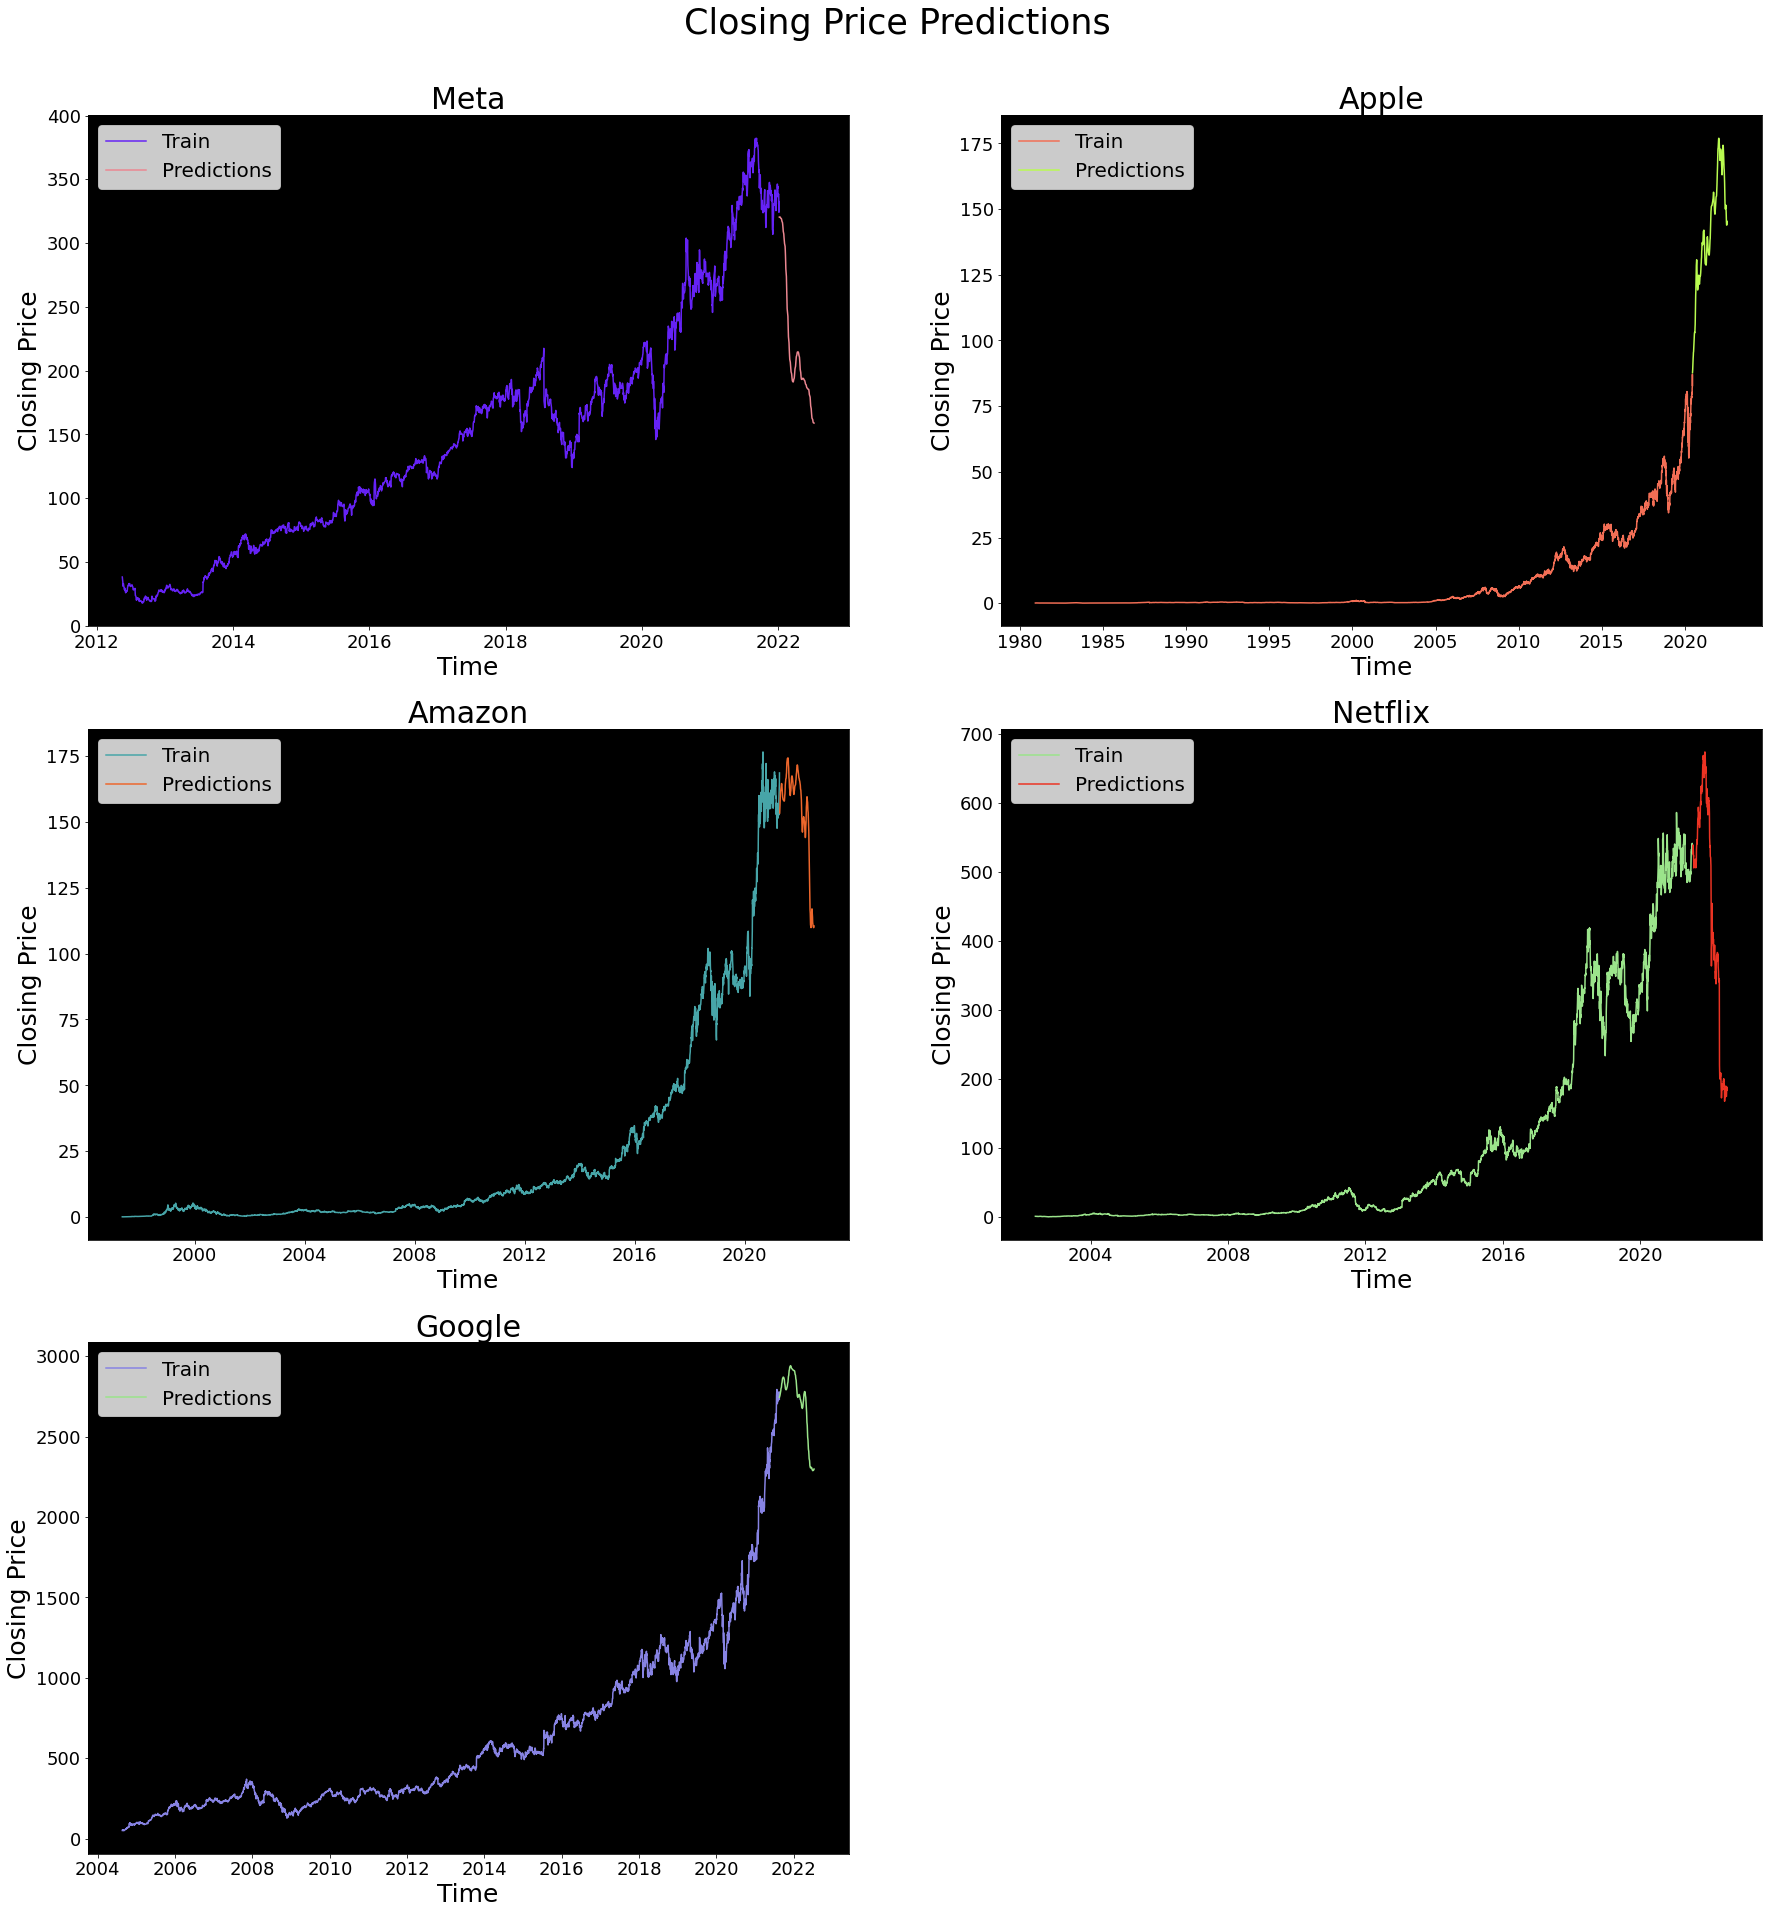

In [19]:
#Plot the model predictions
def plot_model_predictions(plot_train_meta, plot_test_meta, plot_train_aapl, plot_test_aapl, plot_train_amzn, 
                           plot_test_amzn, plot_train_nflx, plot_test_nflx, plot_train_goog, plot_test_goog):
    
    fig, axes = plt.subplots(3, 2, figsize = (30, 30))
    axes[2][1].set_visible(False)
    
    plt.suptitle('Closing Price Predictions', verticalalignment = 'top', horizontalalignment = 'center', fontsize = 35)
# Meta
    axes[0][0].set_facecolor('black')
    axes[0][0].plot(plot_train_meta['Date'], plot_train_meta['Close'], color = '#6522F5', label = 'Train')
    axes[0][0].plot(plot_test_meta['Date'], plot_test_meta['Predictions'], color = '#EB8791', label = 'Predictions')
    axes[0][0].set_title('Meta', fontsize = 30)
    axes[0][0].set_xlabel('Time', fontsize = 25)
    axes[0][0].set_ylabel('Closing Price', fontsize = 25)
    axes[0][0].xaxis.set_tick_params(labelsize = 18)
    axes[0][0].yaxis.set_tick_params(labelsize = 18)
    axes[0][0].legend(loc = 'upper left', fontsize = 20)
# Apple    
    axes[0][1].set_facecolor('black')
    axes[0][1].plot(plot_train_aapl['Date'], plot_train_aapl['Close'], color = '#F26E55', label = 'Train')
    axes[0][1].plot(plot_test_aapl['Date'], plot_test_aapl['Predictions'], color = '#B9FB50', label = 'Predictions')
    axes[0][1].set_title('Apple', fontsize = 30)
    axes[0][1].set_xlabel('Time', fontsize = 25)
    axes[0][1].set_ylabel('Closing Price', fontsize = 25)
    axes[0][1].xaxis.set_tick_params(labelsize = 18)
    axes[0][1].yaxis.set_tick_params(labelsize = 18)
    axes[0][1].legend(loc = 'upper left', fontsize = 20)
# Amazon    
    axes[1][0].set_facecolor('black')
    axes[1][0].plot(plot_train_amzn['Date'], plot_train_amzn['Close'], color = '#47A5A8', label = 'Train')
    axes[1][0].plot(plot_test_amzn['Date'], plot_test_amzn['Predictions'], color = '#ED672C', label = 'Predictions')
    axes[1][0].set_title('Amazon', fontsize = 30)
    axes[1][0].set_xlabel('Time', fontsize = 25)
    axes[1][0].set_ylabel('Closing Price', fontsize = 25)
    axes[1][0].xaxis.set_tick_params(labelsize = 18)
    axes[1][0].yaxis.set_tick_params(labelsize = 18)
    axes[1][0].legend(loc = 'upper left', fontsize = 20)
# Netflix    
    axes[1][1].set_facecolor('black')
    axes[1][1].plot(plot_train_nflx['Date'], plot_train_nflx['Close'], color = '#9BE48B', label = 'Train')
    axes[1][1].plot(plot_test_nflx['Date'], plot_test_nflx['Predictions'], color = '#EB3323', label = 'Predictions')
    axes[1][1].set_title('Netflix', fontsize = 30)
    axes[1][1].set_xlabel('Time', fontsize = 25)
    axes[1][1].set_ylabel('Closing Price', fontsize = 25)
    axes[1][1].xaxis.set_tick_params(labelsize = 18)
    axes[1][1].yaxis.set_tick_params(labelsize = 18)
    axes[1][1].legend(loc = 'upper left', fontsize = 20)
# Google    
    axes[2][0].set_facecolor('black')
    axes[2][0].plot(plot_train_goog['Date'], plot_train_goog['Close'], color = '#8783E3', label = 'Train')
    axes[2][0].plot(plot_test_goog['Date'], plot_test_goog['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[2][0].set_title('Google', fontsize = 30)
    axes[2][0].set_xlabel('Time', fontsize = 25)
    axes[2][0].set_ylabel('Closing Price', fontsize = 25)
    axes[2][0].xaxis.set_tick_params(labelsize = 18)
    axes[2][0].yaxis.set_tick_params(labelsize = 18)
    axes[2][0].legend(loc = 'upper left', fontsize = 20)
    
    plt.subplots_adjust(top = 0.93)
    plt.show()
    
plot_model_predictions(plot_train_meta, plot_test_meta, plot_train_aapl, plot_test_aapl, plot_train_amzn, 
                           plot_test_amzn, plot_train_nflx, plot_test_nflx, plot_train_goog, plot_test_goog)

# Predictions Using ARIMA
ARIMA stands for ***Auto Regessive Integrated Moving Average***. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through the actual values. An ARIMA model can be understood by outlining each of its components as follows:
> - **Auto Regression (AR)**: Refers to a model that shows a changing variable that regresses on its own lagged or prior values.
> - **Integrated (I)**: Represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).
> - **Moving Average (MA)**: Incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<br>

The important parameters of an ARIMA model are as follows:
> - **p**: The number of lag observations in the model also known as the lag order.
> - **d**: The number of times that the raw observations are differenced also known as the degree of differencing.
> - **q**: The size of the moving average window also known as the order of the moving average.

<br>
Block diagram of the ARIMA model:

<img src = "https://www.researchgate.net/profile/Abdellatif-Elmouatamid/publication/336021949/figure/fig3/AS:911704808488962@1594378773709/Different-iterative-steps-of-ARIMA-model.ppm">

### Stationarity
A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary. The trend and seasonality will affect the value of the time series at different times.

### ADF Test
ADF stands for ***Augmented Dickey Fuller***. It is a common statistical test used to test whether a given time series is stationary or not. The null hypothesis of the ADF test is that the time series is non stationary. If the **p-value** of the test is less than the significance level (**0.05**), then we can reject the null hypothesis and infer that the time series is stationary.

If the **p-value > 0.05** we need to find the order of differencing.

In [20]:
#Subset the data 
new_meta_df = df_meta[candlestick_chart_data]
new_aapl_df = df_aapl[candlestick_chart_data]
new_amzn_df = df_amzn[candlestick_chart_data]
new_nflx_df = df_nflx[candlestick_chart_data]
new_goog_df = df_goog[candlestick_chart_data]

#Perform ADF test and print the statistics
def adf_test(dataframe, company):
    result = adfuller(dataframe['Close'])
    print('=========For {}========='.format(company))
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    
adf_test(new_meta_df, 'Meta')
adf_test(new_aapl_df, 'Apple')
adf_test(new_amzn_df, 'Amazon')
adf_test(new_nflx_df, 'Netflix')
adf_test(new_goog_df ,'Google')

=========For Meta=========
ADF Statistic: -1.5324616350899254
p-value: 0.5173963107805681
=========For Apple=========
ADF Statistic: 2.996769292859
p-value: 1.0
=========For Amazon=========
ADF Statistic: 0.0027973693544609355
p-value: 0.9587628160552026
=========For Netflix=========
ADF Statistic: -1.3647523766972665
p-value: 0.5990528272215918
=========For Google=========
ADF Statistic: 0.8362706260178905
p-value: 0.9921996482625179


We need to find the order of differencing for all the companies since their **p-value** is greater than **0.05**.

In [21]:
#Calculate the degree of differencing
def get_degree_of_differencing(dataframe, company):
    company_ndiffs = ndiffs(dataframe['Close'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {company}')
    return company_ndiffs

meta_dd = get_degree_of_differencing(new_meta_df, 'Meta')
aapl_dd = get_degree_of_differencing(new_aapl_df, 'Apple')
amzn_dd = get_degree_of_differencing(new_amzn_df, 'Amazon')
nflx_dd = get_degree_of_differencing(new_nflx_df, 'Netflix')
goog_dd = get_degree_of_differencing(new_goog_df ,'Google')

The degree of differencing is 1 for Meta
The degree of differencing is 1 for Apple
The degree of differencing is 1 for Amazon
The degree of differencing is 1 for Netflix
The degree of differencing is 1 for Google


We make use of the **`auto_arima`** method in the `pmdarima` package that automatically helps us select the best ARIMA model. In order to find the best model `auto_arima` optimizes for a given `information_criterion` and returns the ARIMA model which minimizes that value. The `information_criterion` selected is **`aic`** which stands for **Akaike Information Criterion**. It is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data.

The formula of AIC is as follows:

<img src = "https://miro.medium.com/max/804/1*bgl56Syga-_2SFhQmgShnw.png" width = 250>

where:

**k**: Represents the number of estimated parameters in the model

**$\hat{L}$**: Represents maximum value of the likelihood function for the model

In [22]:
#Splitting the data: Train 95%, Test 5%
def arima_split(dataframe, company):
    size = int(len(dataframe) * 0.95)
    train = (dataframe['Close'])[:size]
    test = (dataframe['Close'])[size:]
    
    print('=========For {}========='.format(company))
    print('Train Size: {}, Test Size: {}'.format(len(train), len(test)))
    
    return train, test
#Save the train and test data
meta_train, meta_test = arima_split(new_meta_df, 'Meta')
aapl_train, aapl_test = arima_split(new_aapl_df, 'Apple')
amzn_train, amzn_test = arima_split(new_amzn_df, 'Amazon')
nflx_train, nflx_test = arima_split(new_nflx_df, 'Netflix')
goog_train, goog_test = arima_split(new_goog_df, 'Google')

=========For Meta=========
Train Size: 2425, Test Size: 128
=========For Apple=========
Train Size: 9958, Test Size: 525
=========For Amazon=========
Train Size: 6014, Test Size: 317
=========For Netflix=========
Train Size: 4815, Test Size: 254
=========For Google=========
Train Size: 4279, Test Size: 226


In [23]:
#Find the best fit using ARIMA
def find_best_fit_arima(data, company):
    print('=========For {}========='.format(company))

# Auto ARIMA optimizes the hyperparameters to find the best fit
    model = pm.auto_arima(data, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model

# Save the model    
meta_arima_model = find_best_fit_arima(meta_train, 'Meta')
aapl_arima_model = find_best_fit_arima(aapl_train, 'Apple')
amzn_arima_model = find_best_fit_arima(amzn_train, 'Amazon')
nflx_arima_model = find_best_fit_arima(nflx_train, 'Netflix')
goog_arima_model = find_best_fit_arima(goog_train, 'Google')

=========For Meta=========
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=3.30 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=15380.713, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=13676.453, Time=0.95 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=14338.489, Time=1.03 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=15388.594, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=14207.895, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=13358.879, Time=1.83 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=7.12 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=15334.467, Time=1.18 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=13349.944, Time=2.36 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=13656.350, Time=1.04 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=5.56 sec
 ARIMA(2,0,1)(2,1,0)[3

**Note**: To avoid *out of memory errors* the value of **`m`** was set to 3. Changing the parameters of the ARIMA model can alos lead to a lower RMSE score.

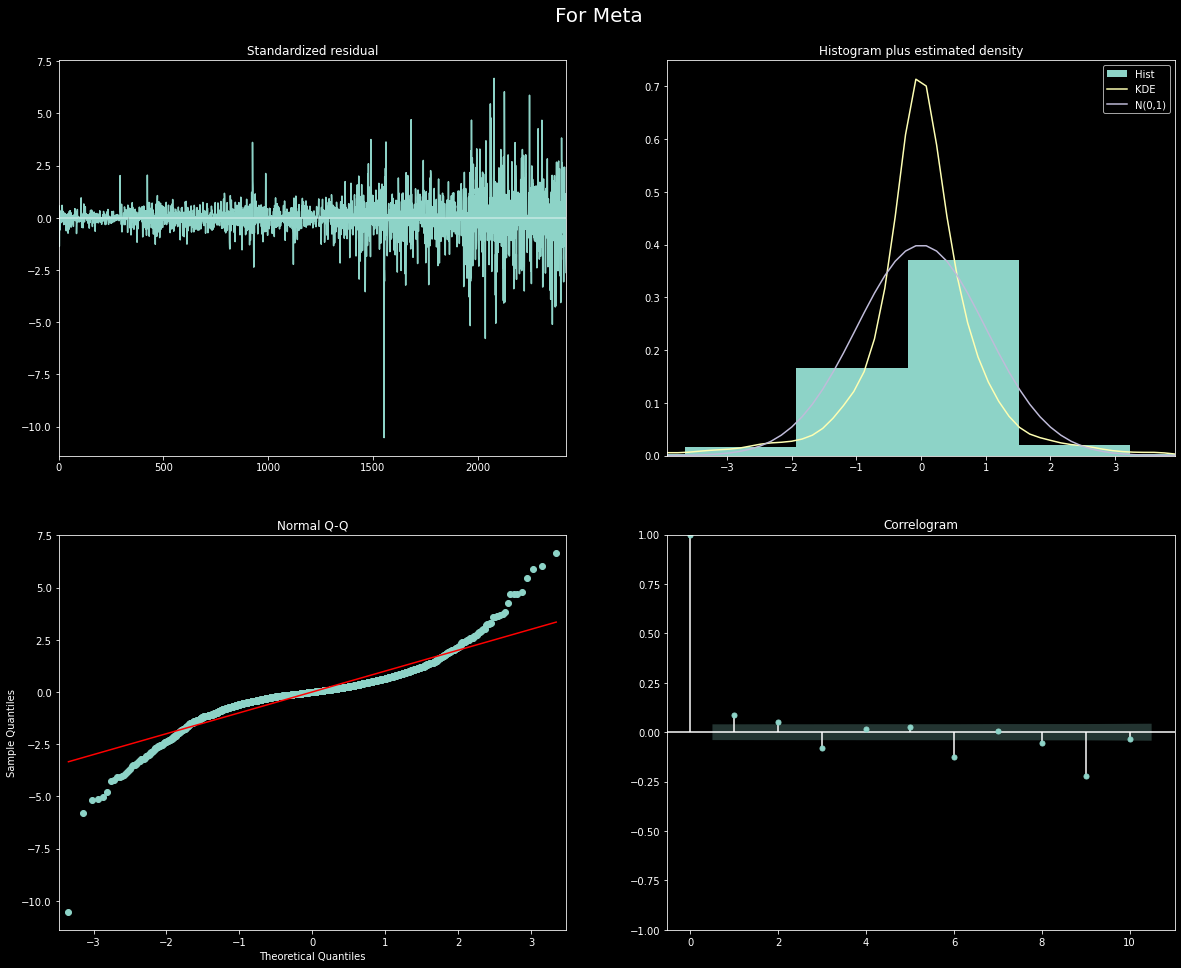

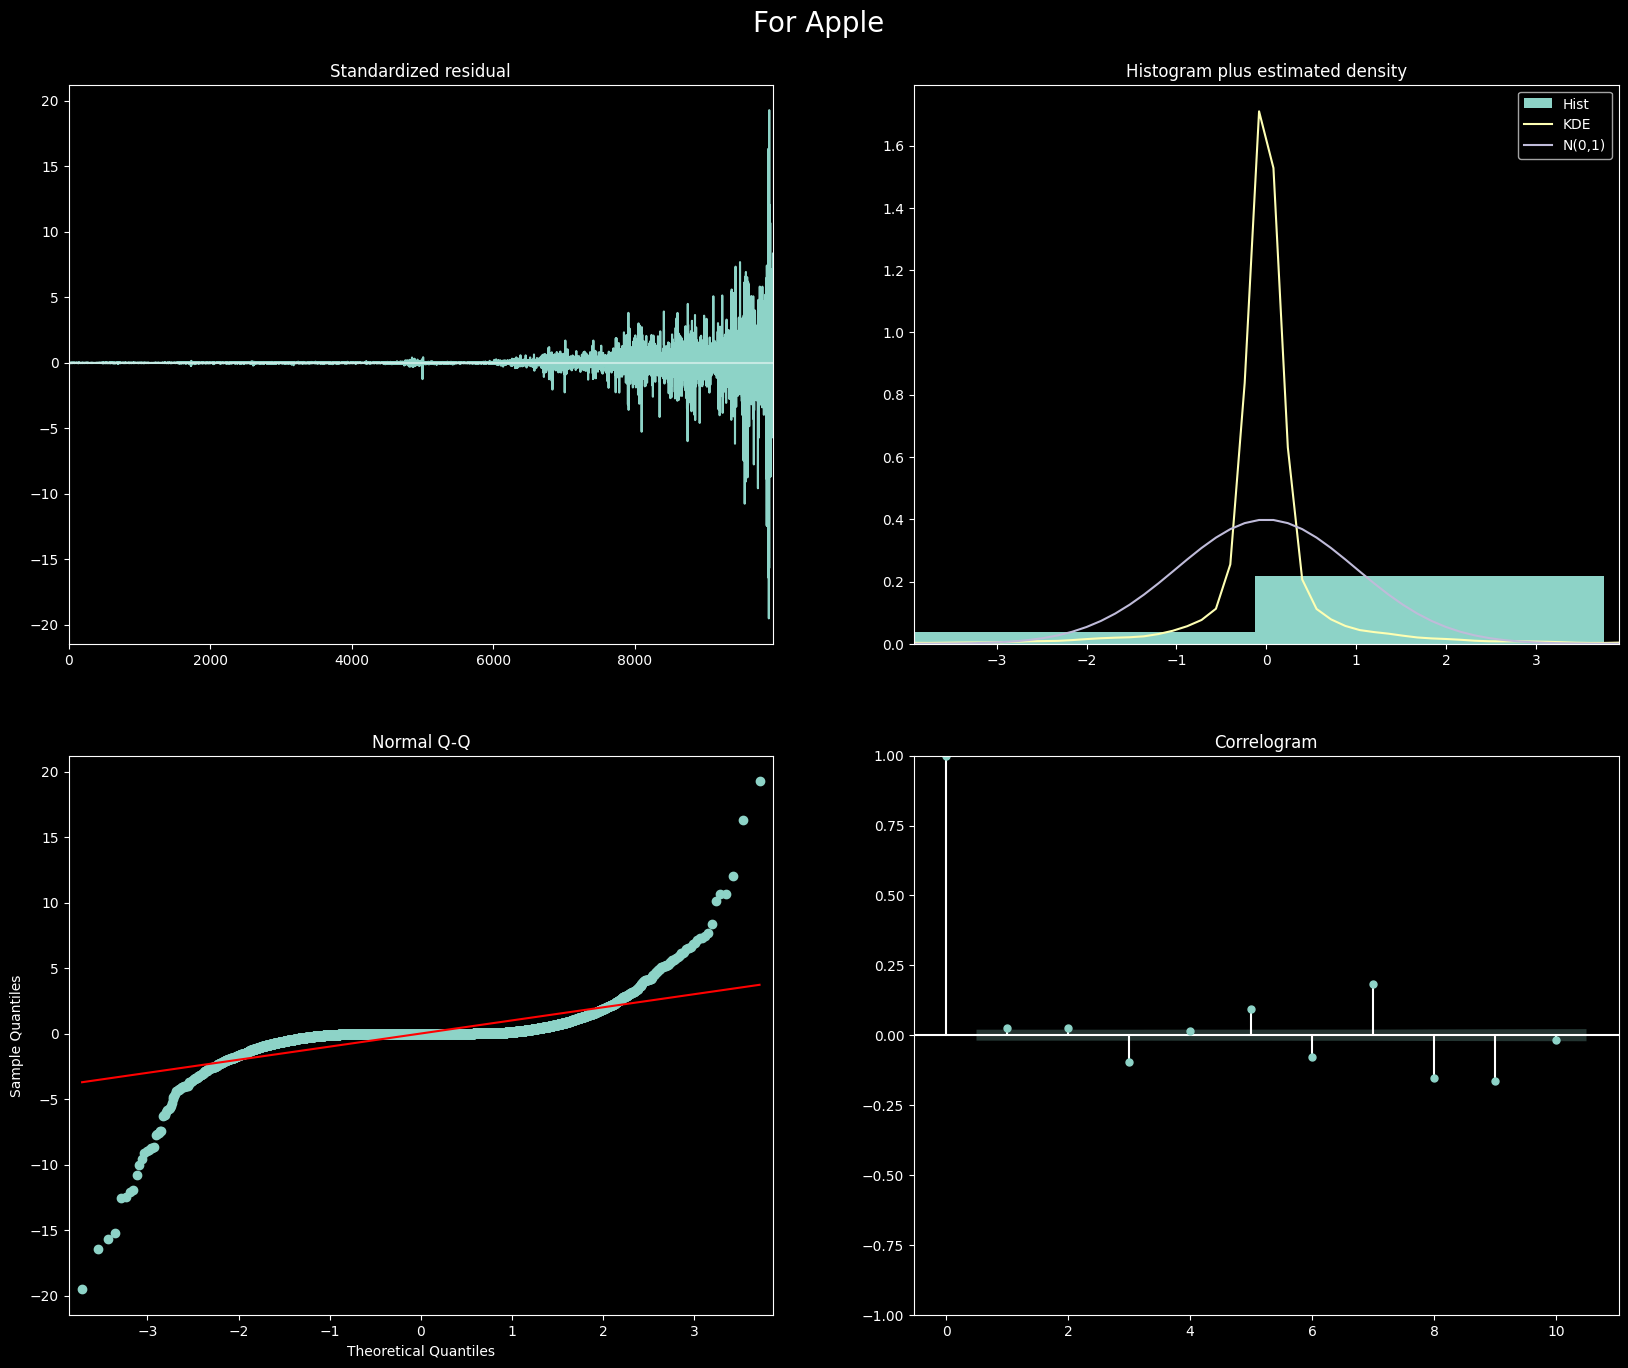

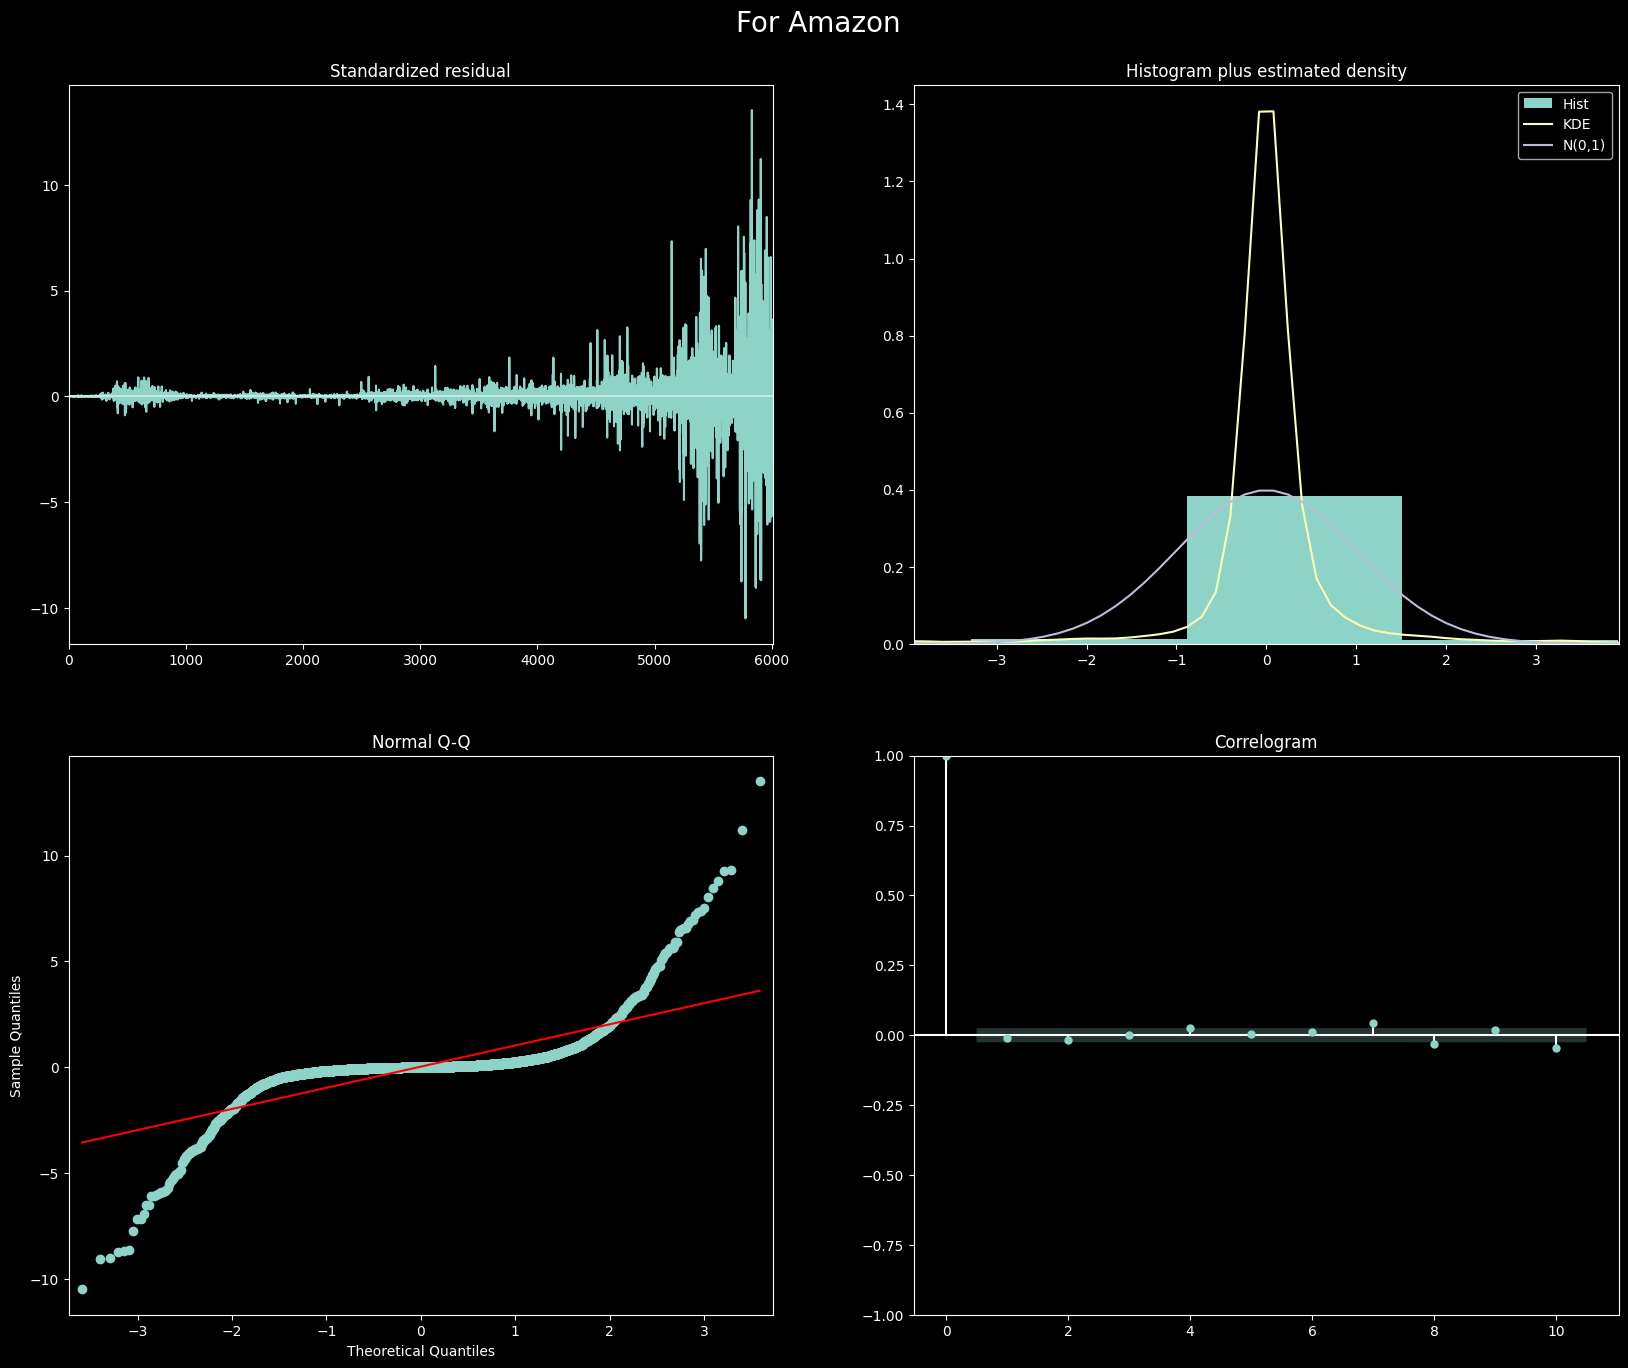

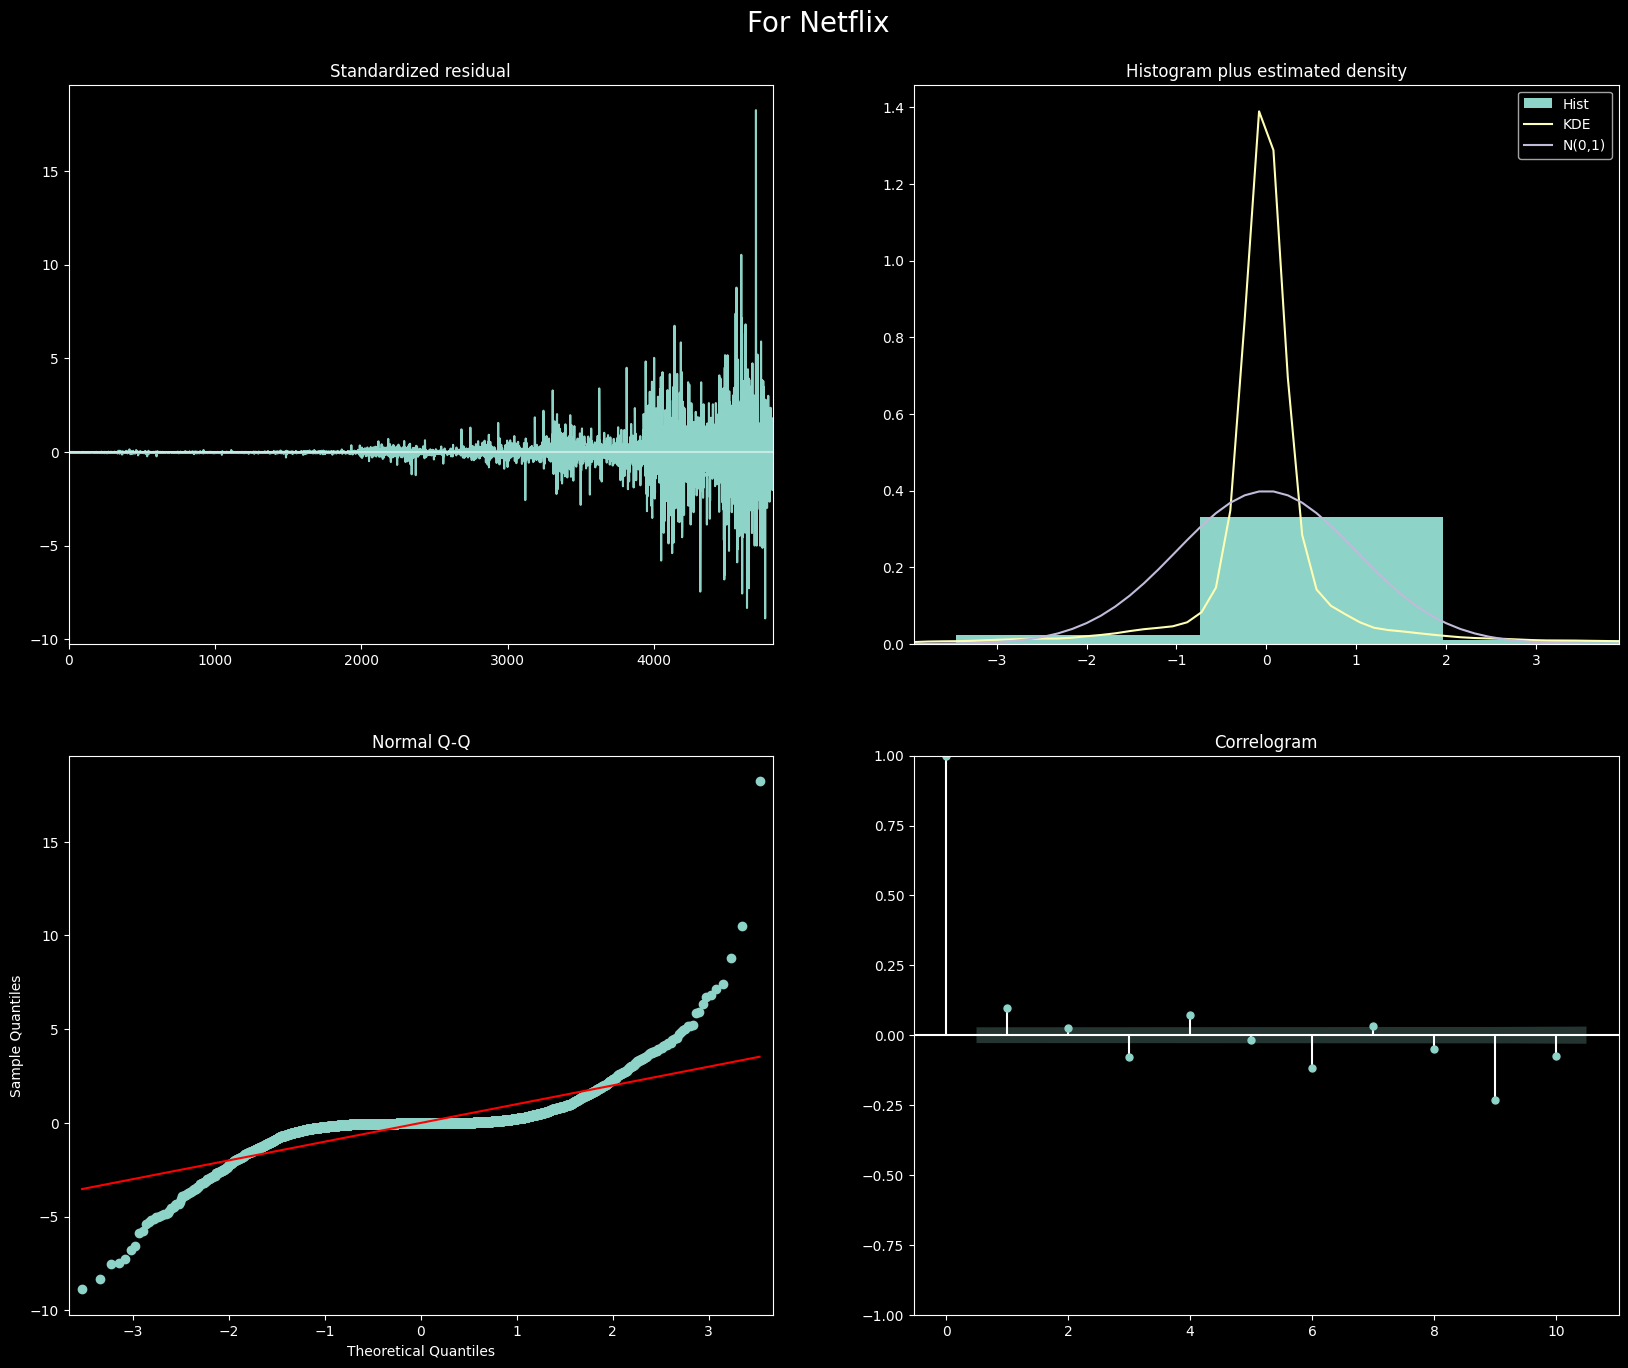

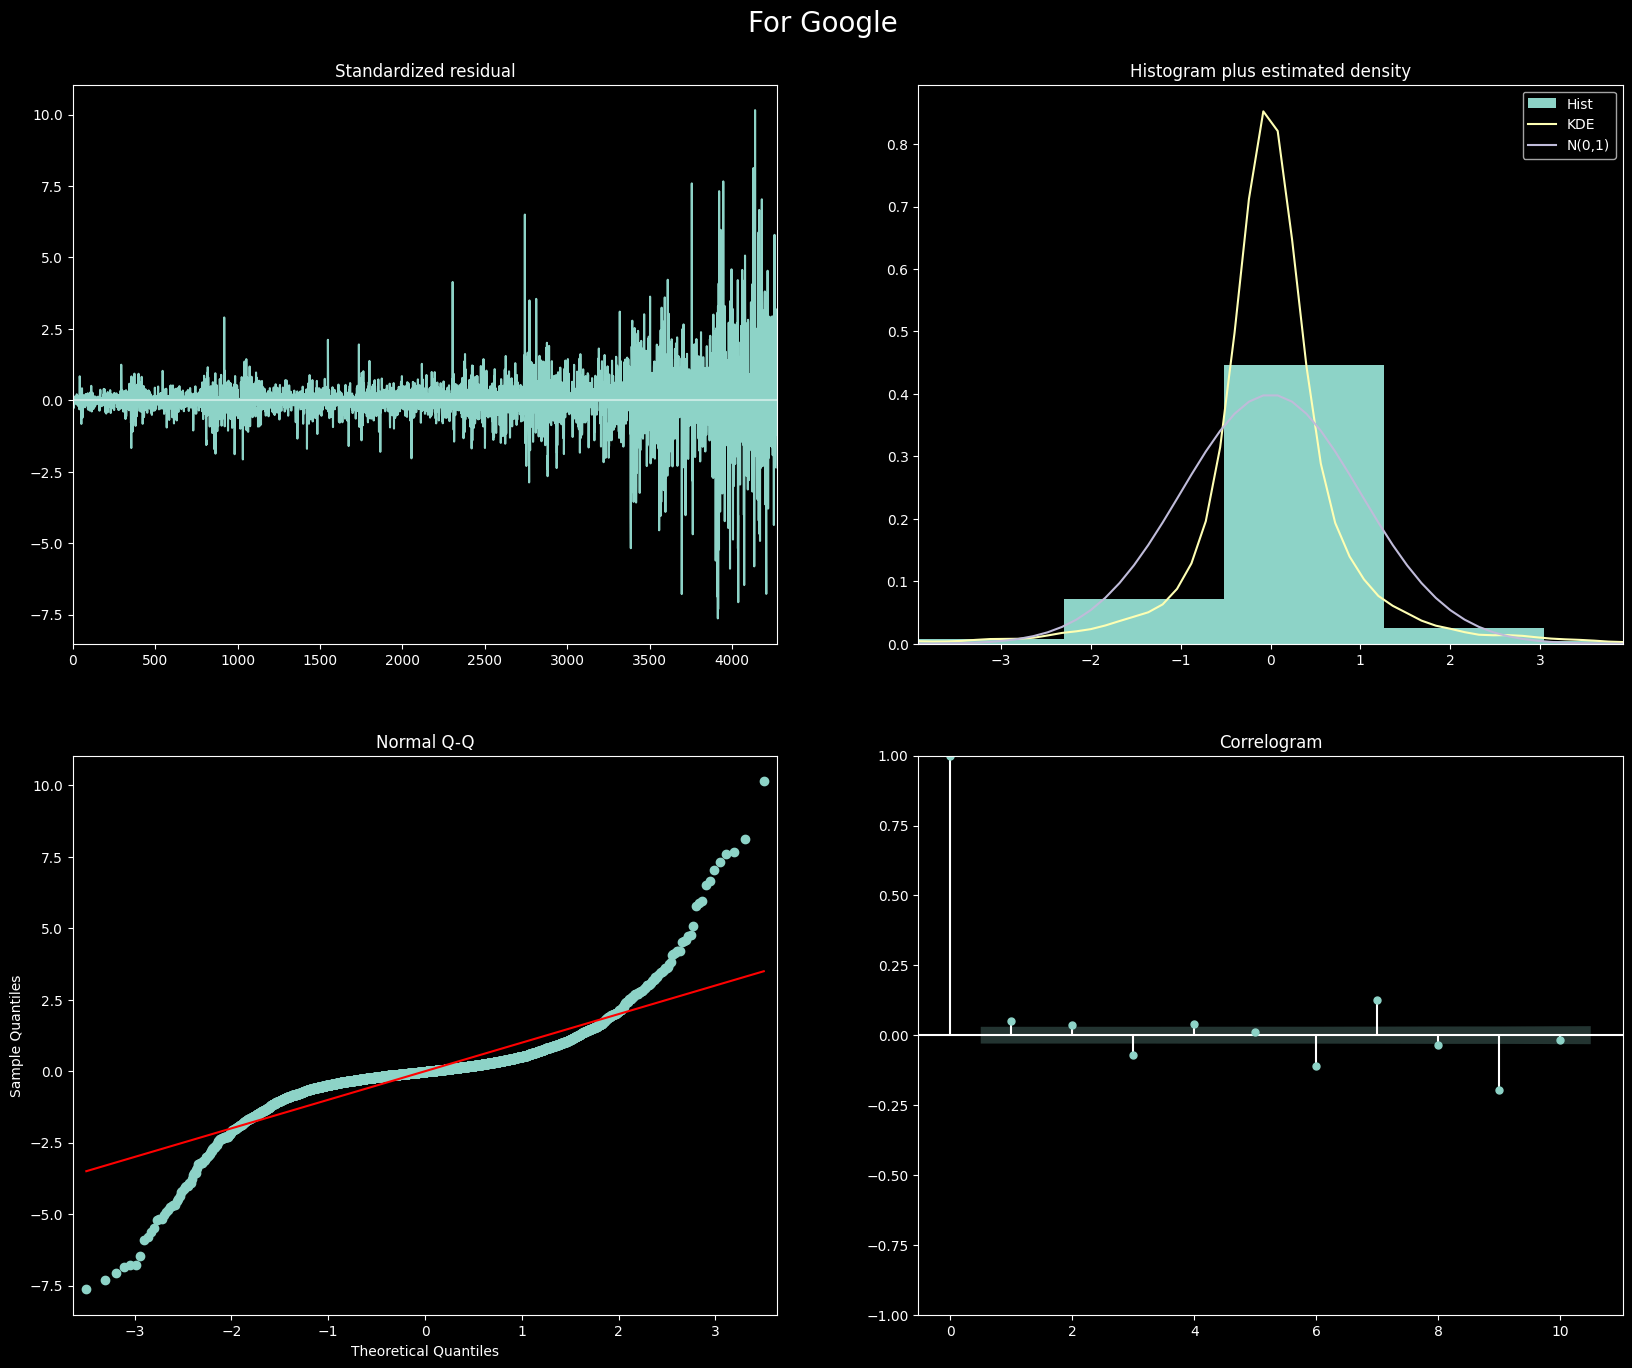

In [24]:
#Visualise the model results and plot diagnostics
def display_model_plots(model, company):
    plt.style.use('dark_background')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle('For {}'.format(company), fontsize = 20)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')
    
display_model_plots(meta_arima_model, 'Meta')
display_model_plots(aapl_arima_model, 'Apple')
display_model_plots(amzn_arima_model, 'Amazon')
display_model_plots(nflx_arima_model, 'Netflix')
display_model_plots(goog_arima_model, 'Google')

Lets try and understand what each of the plots mean:
> - **Standard Residual**: The residual errors seem to fluctuate around a mean of zero.
> - **Histograms plus estimated density**: The density plots represent a normal distribution. The **KDE** (Kernel Density Estimator) is also shown. **N(0, 1)** is another way of saying that the graph is a normal distribution with mean of 0 and variance of 1.
> - **Normal Q-Q**: Mostly the dots fall in line with the red line. Any significant deviations would imply the distribution is skewed.
> - **Correlogram**: A correlogram, also called an **ACF (Auto Correlation Function)** plot is a visual way to show serial correlation in data that changes over time. 

In [25]:
# Print the best parameters for the model
def check_model_params(model, company):
    print('The best parameters for {} are {}'.format(company, model))
    print('==================')
    
check_model_params(meta_arima_model, 'Meta')
check_model_params(aapl_arima_model, 'Apple')
check_model_params(amzn_arima_model, 'Amazon')
check_model_params(nflx_arima_model, 'Netflix')
check_model_params(goog_arima_model, 'Google')

The best parameters for Meta are  ARIMA(2,0,1)(2,1,0)[3] intercept
The best parameters for Apple are  ARIMA(2,0,1)(2,1,0)[3] intercept
The best parameters for Amazon are  ARIMA(2,0,1)(2,1,2)[3]          
The best parameters for Netflix are  ARIMA(2,0,1)(2,1,0)[3] intercept
The best parameters for Google are  ARIMA(2,0,1)(2,1,0)[3] intercept


In [26]:
# Make the predictions and print the rmse for FAANG
def make_predictions_and_print_rmse(model, test_data, company):
    print('=========For {}========='.format(company))
    
    forecast, confidence_interval = model.predict(X = test_data, n_periods = len(test_data), return_conf_int = True)
    forecast = pd.Series(forecast, index = test_data[:len(test_data)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_data[:len(test_data)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_data[:len(test_data)].index)
    
    rmse = np.sqrt(np.mean((forecast - test_data) ** 2))
    
    print('The RMSE is {}'.format(rmse))
    
    return forecast, lower, upper

forecast_meta, lower_meta, upper_meta = make_predictions_and_print_rmse(meta_arima_model, meta_test, 'Meta')
forecast_aapl, lower_aapl, upper_aapl = make_predictions_and_print_rmse(aapl_arima_model, aapl_test, 'Apple')
forecast_amzn, lower_amzn, upper_amzn = make_predictions_and_print_rmse(amzn_arima_model, amzn_test, 'Amazon')
forecast_nflx, lower_nflx, upper_nflx = make_predictions_and_print_rmse(nflx_arima_model, nflx_test, 'Netflix')
forecast_goog, lower_goog, upper_goog = make_predictions_and_print_rmse(goog_arima_model, goog_test, 'Google')

=========For Meta=========
The RMSE is 129.31216289716093
=========For Apple=========
The RMSE is 49.803828285833895
=========For Amazon=========
The RMSE is 24.10281989630944
=========For Netflix=========
The RMSE is 203.81564550295812
=========For Google=========
The RMSE is 324.7720892733972


In [27]:
#Function to create a dataframe for plotting
def create_df_for_plotting(dataframe, forecast, lower, upper):
    data = {'Date': (dataframe['Date'])[int(len(dataframe) * 0.95):],
            'Predictions': forecast,
            'Lower_conf': lower,
            'Upper_conf': upper}
    
    plot_df = pd.DataFrame(data)
    
    return plot_df
# Save it in a new dataframe
meta_plot_df = create_df_for_plotting(new_meta_df, forecast_meta, lower_meta, upper_meta)
aapl_plot_df = create_df_for_plotting(new_aapl_df, forecast_aapl, lower_aapl, upper_aapl)
amzn_plot_df = create_df_for_plotting(new_amzn_df, forecast_amzn, lower_amzn, upper_amzn)
nflx_plot_df = create_df_for_plotting(new_nflx_df, forecast_nflx, lower_nflx, upper_nflx)
goog_plot_df = create_df_for_plotting(new_goog_df, forecast_goog, lower_goog, upper_goog)

meta_plot_df.head()

Date  Predictions  Lower_conf  Upper_conf
2425 2022-01-06   327.592277  320.158866  335.025688
2426 2022-01-07   334.010617  324.499141  343.522094
2427 2022-01-10   328.569542  317.770584  339.368499
2428 2022-01-11   330.992045  318.311201  343.672888
2429 2022-01-12   333.824816  319.959457  347.690174

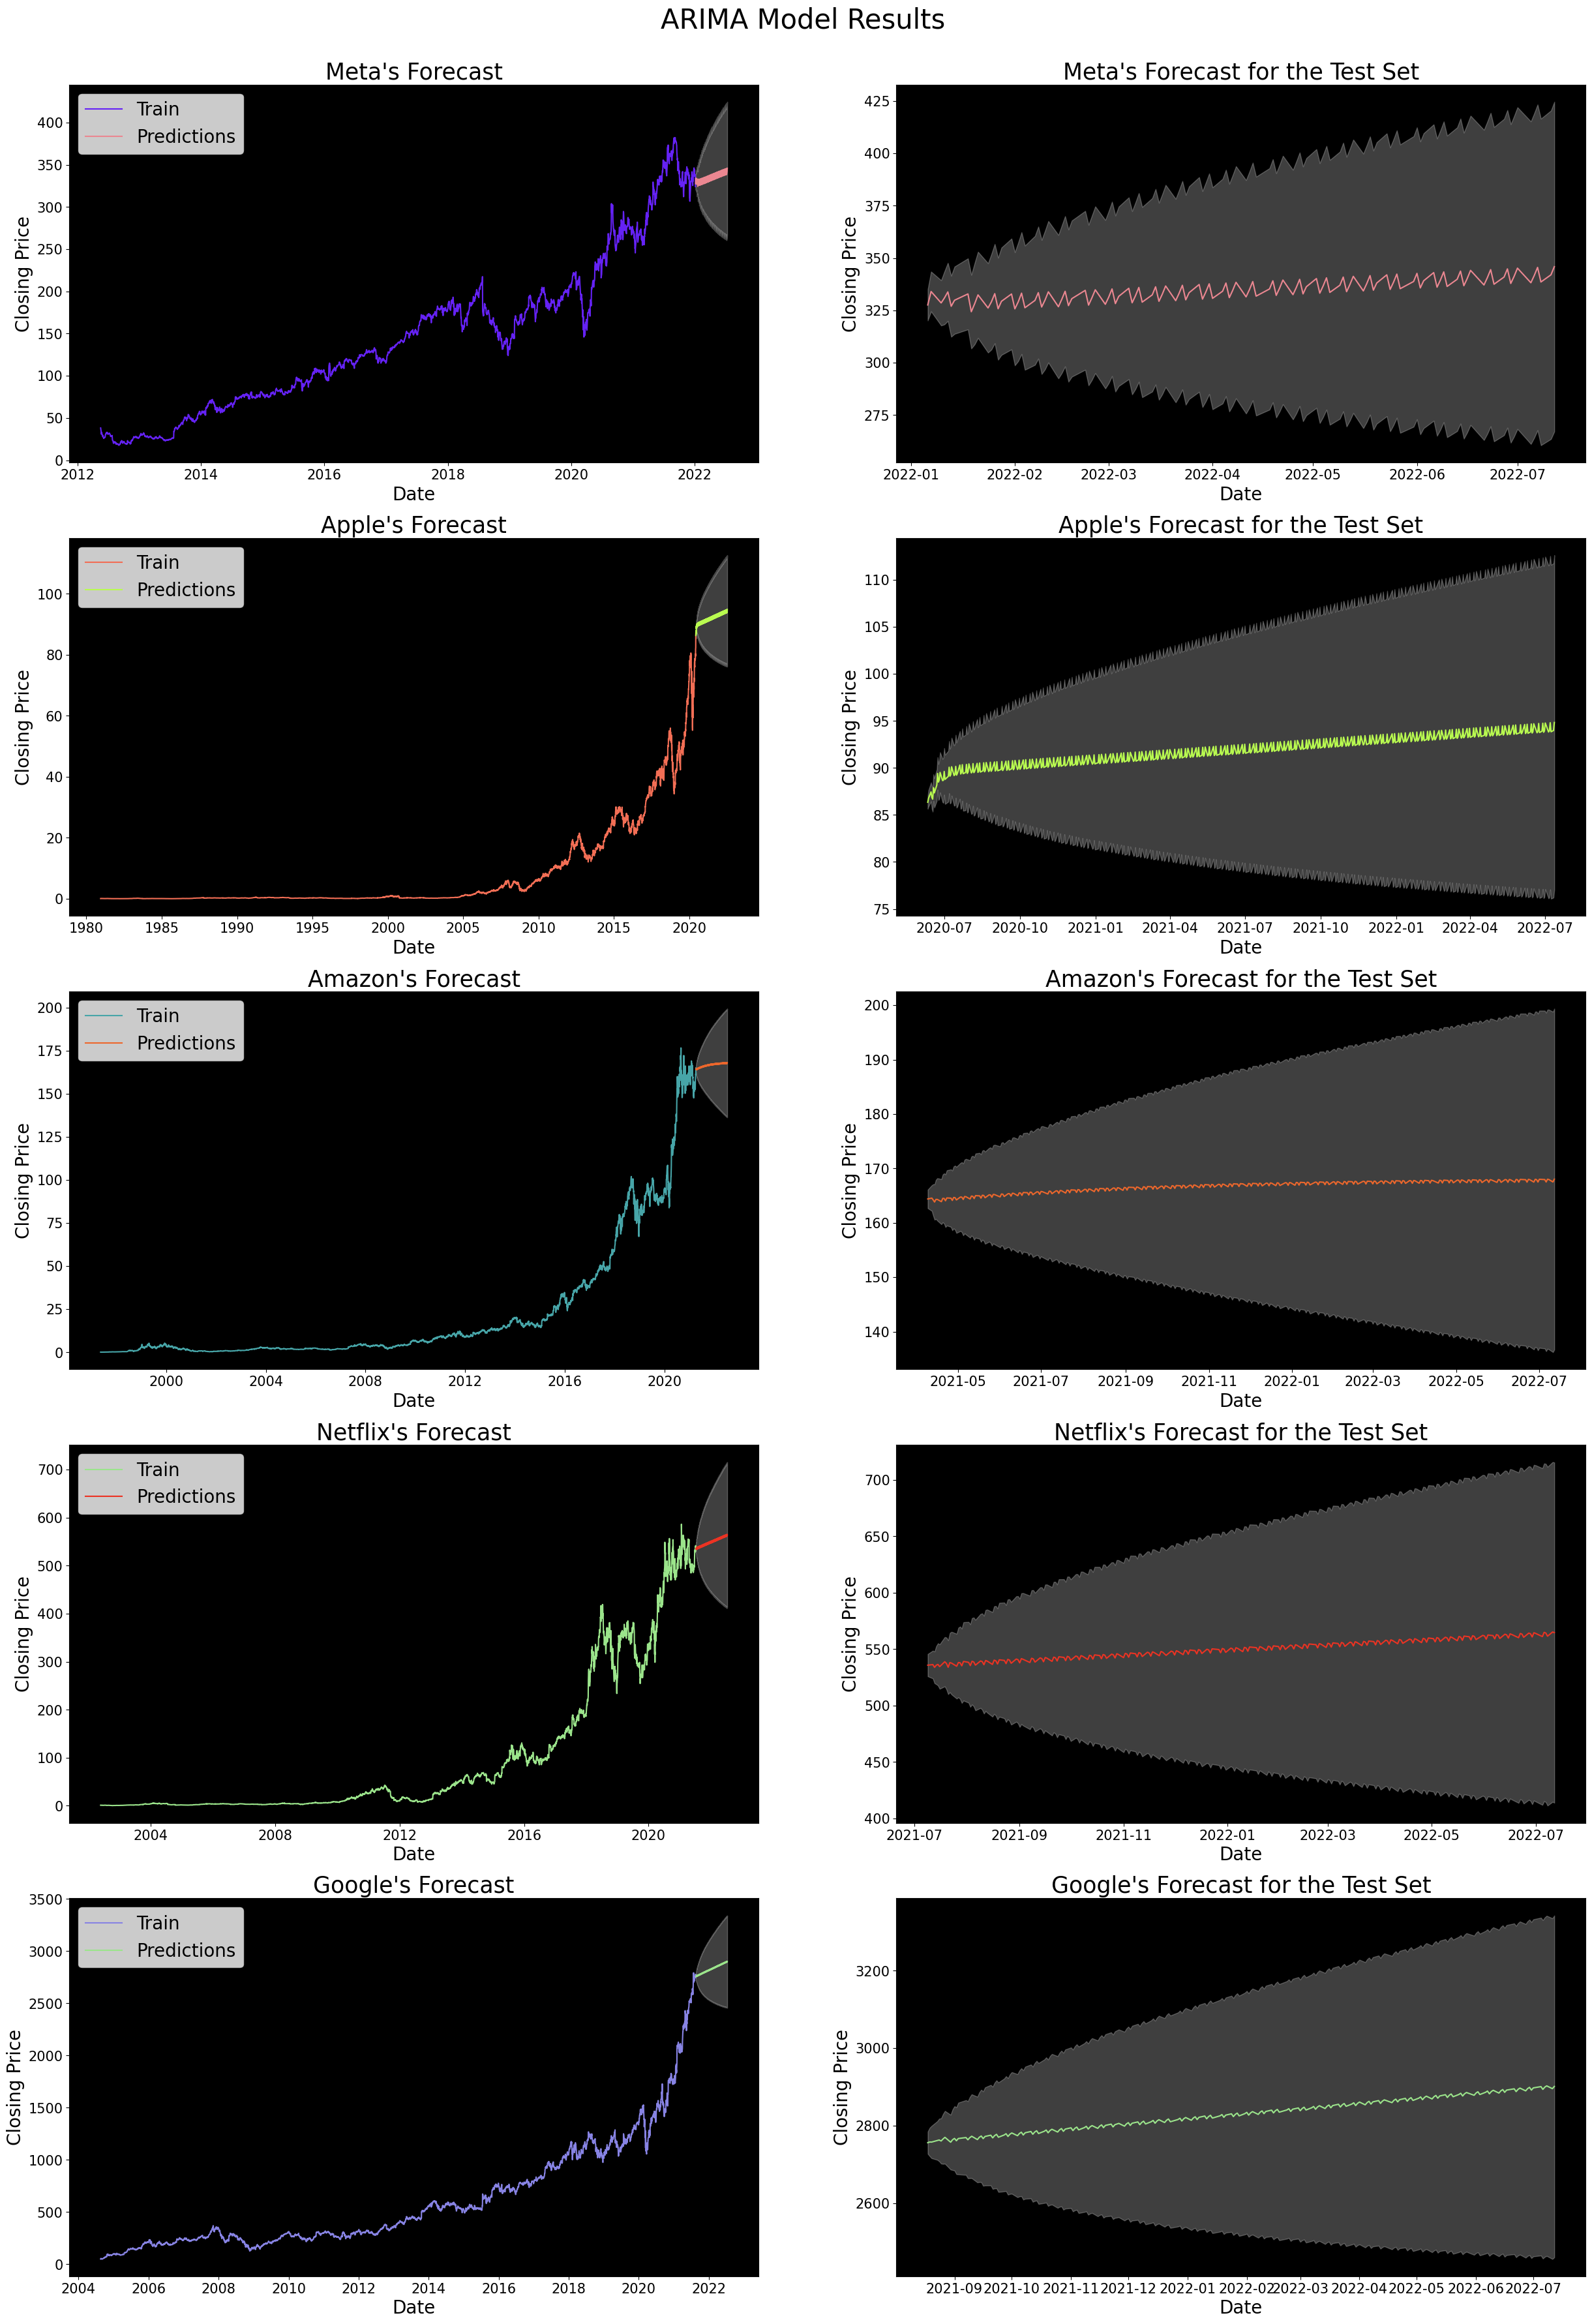

In [28]:
#Print the results
def show_arima_results(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df,
    meta_plot_df, aapl_plot_df, amzn_plot_df, nflx_plot_df, goog_plot_df):
    
    fig, axes = plt.subplots(5, 2, figsize = (30, 40))    
    plt.suptitle('ARIMA Model Results', fontsize = 30)
# Meta    
    axes[0][0].set_facecolor('black')
    axes[0][0].set_title("Meta's Forecast", fontsize = 25)
    axes[0][0].plot((new_meta_df['Date'])[:int(len(new_meta_df) * 0.95)], meta_train, color = '#6522F5', label = 'Train')
    axes[0][0].plot((new_meta_df['Date'])[int(len(new_meta_df) * 0.95):], meta_plot_df['Predictions'], color = '#EB8791', label = 'Predictions')
    axes[0][0].fill_between(meta_plot_df['Date'].values, 
                     meta_plot_df['Lower_conf'], 
                     meta_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[0][0].set_xlabel('Date', fontsize = 20)
    axes[0][0].set_ylabel('Closing Price', fontsize = 20)
    axes[0][0].xaxis.set_tick_params(labelsize = 15)
    axes[0][0].yaxis.set_tick_params(labelsize = 15)
    axes[0][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[0][1].set_title("Meta's Forecast for the Test Set", fontsize = 25)
    axes[0][1].set_facecolor('black')
    axes[0][1].plot((new_meta_df['Date'])[int(len(new_meta_df) * 0.95):], forecast_meta, color = '#EB8791')
    axes[0][1].fill_between(meta_plot_df['Date'].values, 
                     meta_plot_df['Lower_conf'], 
                     meta_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[0][1].set_xlabel('Date', fontsize = 20)
    axes[0][1].set_ylabel('Closing Price', fontsize = 20)
    axes[0][1].xaxis.set_tick_params(labelsize = 15)
    axes[0][1].yaxis.set_tick_params(labelsize = 15)
# Apple    
    axes[1][0].set_facecolor('black')
    axes[1][0].set_title("Apple's Forecast", fontsize = 25)
    axes[1][0].plot((new_aapl_df['Date'])[:int(len(new_aapl_df) * 0.95)], aapl_train, color = '#F26E55', label = 'Train')
    axes[1][0].plot((new_aapl_df['Date'])[int(len(new_aapl_df) * 0.95):], aapl_plot_df['Predictions'], color = '#B9FB50', label = 'Predictions')
    axes[1][0].fill_between(aapl_plot_df['Date'].values, 
                     aapl_plot_df['Lower_conf'], 
                     aapl_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[1][0].set_xlabel('Date', fontsize = 20)
    axes[1][0].set_ylabel('Closing Price', fontsize = 20)
    axes[1][0].xaxis.set_tick_params(labelsize = 15)
    axes[1][0].yaxis.set_tick_params(labelsize = 15)
    axes[1][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[1][1].set_title("Apple's Forecast for the Test Set", fontsize = 25)
    axes[1][1].set_facecolor('black')
    axes[1][1].plot((new_aapl_df['Date'])[int(len(new_aapl_df) * 0.95):], forecast_aapl, color = '#B9FB50')
    axes[1][1].fill_between(aapl_plot_df['Date'].values, 
                     aapl_plot_df['Lower_conf'], 
                     aapl_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[1][1].set_xlabel('Date', fontsize = 20)
    axes[1][1].set_ylabel('Closing Price', fontsize = 20)
    axes[1][1].xaxis.set_tick_params(labelsize = 15)
    axes[1][1].yaxis.set_tick_params(labelsize = 15)
# Amazon    
    axes[2][0].set_facecolor('black')
    axes[2][0].set_title("Amazon's Forecast", fontsize = 25)
    axes[2][0].plot((new_amzn_df['Date'])[:int(len(new_amzn_df) * 0.95)], amzn_train, color = '#47A5A8', label = 'Train')
    axes[2][0].plot((new_amzn_df['Date'])[int(len(new_amzn_df) * 0.95):], amzn_plot_df['Predictions'], color = '#ED672C', label = 'Predictions')
    axes[2][0].fill_between(amzn_plot_df['Date'].values, 
                     amzn_plot_df['Lower_conf'], 
                     amzn_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[2][0].set_xlabel('Date', fontsize = 20)
    axes[2][0].set_ylabel('Closing Price', fontsize = 20)
    axes[2][0].xaxis.set_tick_params(labelsize = 15)
    axes[2][0].yaxis.set_tick_params(labelsize = 15)
    axes[2][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[2][1].set_title("Amazon's Forecast for the Test Set", fontsize = 25)
    axes[2][1].set_facecolor('black')
    axes[2][1].plot((new_amzn_df['Date'])[int(len(new_amzn_df) * 0.95):], forecast_amzn, color = '#ED672C')
    axes[2][1].fill_between(amzn_plot_df['Date'].values, 
                     amzn_plot_df['Lower_conf'], 
                     amzn_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[2][1].set_xlabel('Date', fontsize = 20)
    axes[2][1].set_ylabel('Closing Price', fontsize = 20)
    axes[2][1].xaxis.set_tick_params(labelsize = 15)
    axes[2][1].yaxis.set_tick_params(labelsize = 15)
# Netflix    
    axes[3][0].set_facecolor('black')
    axes[3][0].set_title("Netflix's Forecast", fontsize = 25)
    axes[3][0].plot((new_nflx_df['Date'])[:int(len(new_nflx_df) * 0.95)], nflx_train, color = '#9BE48B', label = 'Train')
    axes[3][0].plot((new_nflx_df['Date'])[int(len(new_nflx_df) * 0.95):], nflx_plot_df['Predictions'], color = '#EB3323', label = 'Predictions')
    axes[3][0].fill_between(nflx_plot_df['Date'].values, 
                     nflx_plot_df['Lower_conf'], 
                     nflx_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[3][0].set_xlabel('Date', fontsize = 20)
    axes[3][0].set_ylabel('Closing Price', fontsize = 20)
    axes[3][0].xaxis.set_tick_params(labelsize = 15)
    axes[3][0].yaxis.set_tick_params(labelsize = 15)
    axes[3][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[3][1].set_title("Netflix's Forecast for the Test Set", fontsize = 25)
    axes[3][1].set_facecolor('black')
    axes[3][1].plot((new_nflx_df['Date'])[int(len(new_nflx_df) * 0.95):], forecast_nflx, color = '#EB3323')
    axes[3][1].fill_between(nflx_plot_df['Date'].values, 
                     nflx_plot_df['Lower_conf'], 
                     nflx_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[3][1].set_xlabel('Date', fontsize = 20)
    axes[3][1].set_ylabel('Closing Price', fontsize = 20)
    axes[3][1].xaxis.set_tick_params(labelsize = 15)
    axes[3][1].yaxis.set_tick_params(labelsize = 15)
# Google    
    axes[4][0].set_facecolor('black')
    axes[4][0].set_title("Google's Forecast", fontsize = 25)
    axes[4][0].plot((new_goog_df['Date'])[:int(len(new_goog_df) * 0.95)], goog_train, color = '#8783E3', label = 'Train')
    axes[4][0].plot((new_goog_df['Date'])[int(len(new_goog_df) * 0.95):], goog_plot_df['Predictions'], color = '#9BE48B', label = 'Predictions')
    axes[4][0].fill_between(goog_plot_df['Date'].values, 
                     goog_plot_df['Lower_conf'], 
                     goog_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[4][0].set_xlabel('Date', fontsize = 20)
    axes[4][0].set_ylabel('Closing Price', fontsize = 20)
    axes[4][0].xaxis.set_tick_params(labelsize = 15)
    axes[4][0].yaxis.set_tick_params(labelsize = 15)
    axes[4][0].legend(loc = 'upper left', fontsize = 20)
    
    axes[4][1].set_title("Google's Forecast for the Test Set", fontsize = 25)
    axes[4][1].set_facecolor('black')
    axes[4][1].plot((new_goog_df['Date'])[int(len(new_goog_df) * 0.95):], forecast_goog, color = '#9BE48B')
    axes[4][1].fill_between(goog_plot_df['Date'].values, 
                     goog_plot_df['Lower_conf'], 
                     goog_plot_df['Upper_conf'], 
                     color = 'w', alpha = 0.25)
    axes[4][1].set_xlabel('Date', fontsize = 20)
    axes[4][1].set_ylabel('Closing Price', fontsize = 20)
    axes[4][1].xaxis.set_tick_params(labelsize = 15)
    axes[4][1].yaxis.set_tick_params(labelsize = 15)
#Plot        
    plt.subplots_adjust(top = 0.95)
    plt.show()
    
show_arima_results(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df,
                   meta_plot_df, aapl_plot_df, amzn_plot_df, nflx_plot_df, goog_plot_df)

**Observations**: The LSTM models have a much better performance as compared to the ARIMA models. The LSTMs have a much lower ***RMSE*** score and produce better forecasts. The predictions made by the ARIMA models can be improved by experimenting with different parameters of the `auto_arima` function.

# Predictions Using Prophet
Facebook's (now Meta's) Prophet helps forecasting time series data based on an **additive model** where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. **Prophet** is *robust* to missing data and shifts in the trend, and typically handles outliers well.

The mathematical equation behind the Prophet model is defined as:

<img src = "https://miro.medium.com/max/800/1*ghTHwruT5QxQ_g_2rvu-3w.png" width = 350>

> - **g(t)**: Represents the trend. Prophet uses a piecewise linear model for trend forecasting.
> - **s(t)**: Represents periodic changes (weekly, monthly, yearly).
> - **h(t)**: Represents the effects of holidays (Holidays can impact businesses).
> - **ε(t)**: Represents the error term

The Prophet model fitting procedure is usually very fast (even for thousands of observations) and it does not require any data preprocessing. It deals also with **missing data and outliers**.

The input to Prophet is ***always*** a dataframe with two columns: `ds` and `y`. The `ds` column represents the date and the `y` column must be numeric and should be the measurement we wish to forecast. 

In [12]:
#Format the data before modelling
def prophet_formatting(dataframe):
    dataframe = dataframe[['Date', 'Close']] #Subsetting the data
    dataframe = dataframe.rename(columns = {'Date': 'ds', 'Close': 'y'}) # Rename the columns
    return dataframe
#Save it in a new df
meta_prophet_df = prophet_formatting(new_meta_df)
aapl_prophet_df = prophet_formatting(new_aapl_df)
amzn_prophet_df = prophet_formatting(new_amzn_df)
nflx_prophet_df = prophet_formatting(new_nflx_df)
goog_prophet_df = prophet_formatting(new_goog_df)

meta_prophet_df.head()

ds          y
0 2012-05-18  38.230000
1 2012-05-21  34.029999
2 2012-05-22  31.000000
3 2012-05-23  32.000000
4 2012-05-24  33.029999

=========For Meta=========
Initial log joint probability = -18.8247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6915.59   0.000646991       229.665           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6993.32     0.0388939       2409.23           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7043.43     0.0221338       1202.53           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7057.11    0.00259937        115.49           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7063.71    0.00107613        475.39      0.3385      0.7319      576   
    Iter      log prob        ||dx|| 

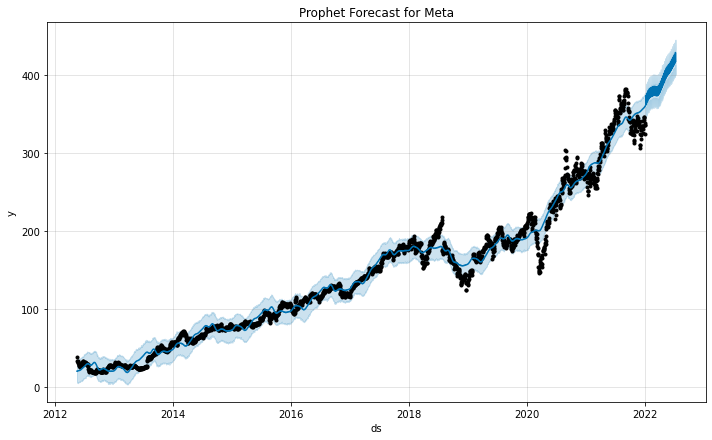

=========For Apple=========
Initial log joint probability = -1046.55
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       27532.4    0.00598637       3039.18      0.2647           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       27714.3    0.00105318       727.044      0.1767      0.1767      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       27770.5    0.00119296       3098.48      0.8217      0.8217      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       27804.1    0.00200716        1315.2           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       27817.7   0.000832737       533.927      0.4448      0.4448      577   
    Iter      log prob        ||dx||

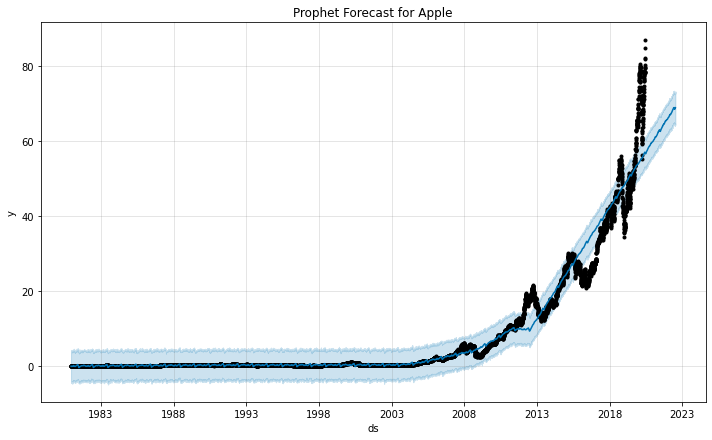

=========For Amazon=========
Initial log joint probability = -445.305
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16734.6    0.00146833       4866.05      0.6102      0.6102      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       16864.4     0.0208153       2703.96           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16919.3     0.0451878        2672.4      0.3904           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       16943.1     0.0142133       1907.64           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       16964.3   0.000179576       840.154   2.538e-07       0.001      593  LS failed, Hessian reset 
     499   

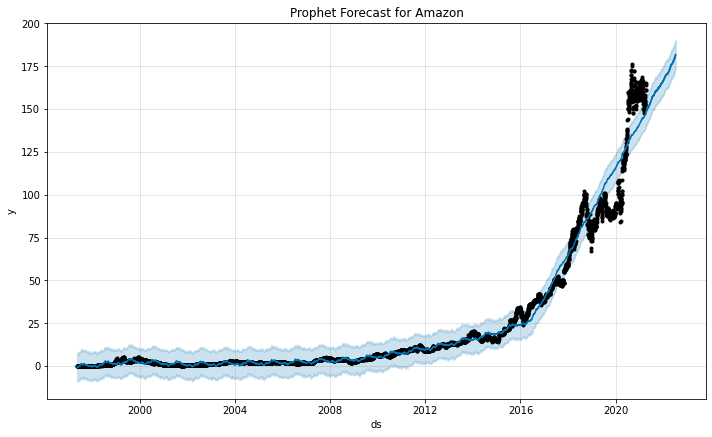

=========For Netflix=========
Initial log joint probability = -258.343
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12596.9     0.0212915       1901.66           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       12670.2    0.00110346       178.857           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12689.7     0.0262268       1010.62           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12712.8   0.000630898        193.44        3.26       0.326      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     468       12719.4   2.84062e-05       125.726   1.586e-07       0.001      582  LS failed, Hessian reset 
     499  

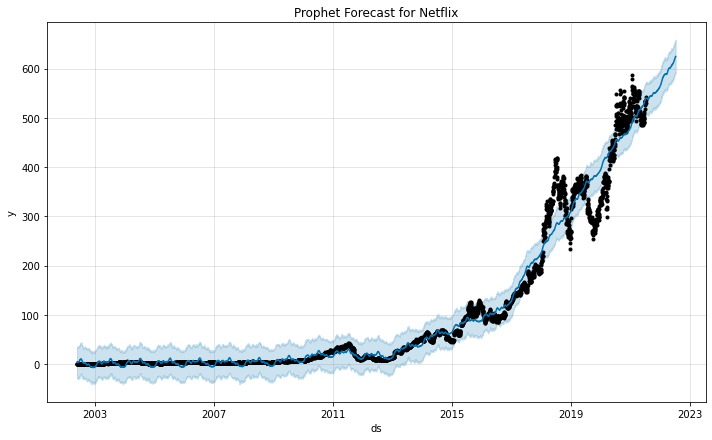

=========For Google=========
Initial log joint probability = -216.633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       11304.5     0.0376096       2153.16           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       11389.8   0.000395499       549.772     0.08782       0.365      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296         11404   7.40079e-05       215.396    1.31e-07       0.001      388  LS failed, Hessian reset 
     299       11404.2    0.00171075        345.69           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         11410    0.00457754        186.63           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499   

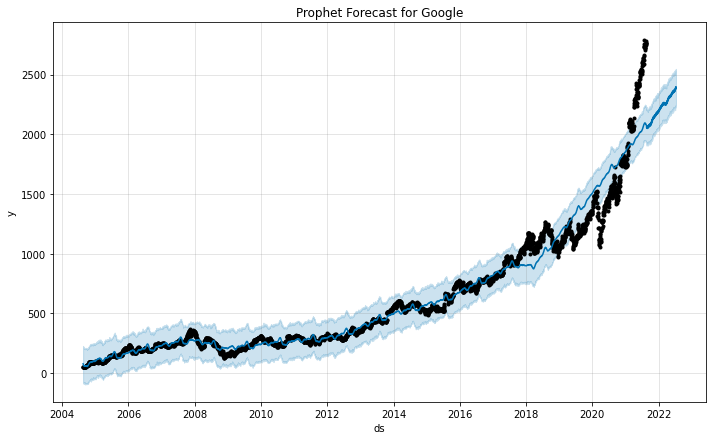

In [26]:
#Function to make predictions with prophet
def make_predictions_with_prophet(data1, company):
    print(f'=========For {company}=========')

    # Splitting the data into training(95%) and testing sets(5%)
    size = int(len(data1) * 0.95)
    train = data1[:size]
    test = data1[size:]

    # Check the format of the date column in test dataframe
    if isinstance(test['ds'].iloc[0], str):
        date_format = '%Y-%m-%d %H:%M:%S' if ' ' in test['ds'].iloc[0] else '%Y-%m-%d'
        t1 = datetime.strptime(test['ds'].iloc[0], date_format)
        t2 = datetime.strptime(test['ds'].iloc[-1], date_format)
    else:
        t1 = test['ds'].iloc[0]
        t2 = test['ds'].iloc[-1]

    time = t2 - t1

    # Create and fit the Prophet model
    model = Prophet()
    model.fit(train)

    # Make future predictions
    future = model.make_future_dataframe(periods=time.days)
    forecast = model.predict(future)

    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f'Prophet Forecast for {company}')
    plt.show()

    return model, train, test, forecast

#Save it in a new df
meta_fbp, meta_train, meta_test, meta_pred = make_predictions_with_prophet(meta_prophet_df, 'Meta')
aapl_fbp, aapl_train, aapl_test, aapl_pred = make_predictions_with_prophet(aapl_prophet_df, 'Apple')
amzn_fbp, amzn_train, amzn_test, amzn_pred = make_predictions_with_prophet(amzn_prophet_df, 'Amazon')
nflx_fbp, nflx_train, nflx_test, nflx_pred = make_predictions_with_prophet(nflx_prophet_df, 'Netflix')
goog_fbp, goog_train, goog_test, goog_pred = make_predictions_with_prophet(goog_prophet_df, 'Google')


In [28]:
#Calculate the RMSE
def calculate_prophet_rmse(pred, test, company):    
    print('=========For {}========='.format(company))
    
    rmse = np.sqrt(np.mean((np.array(pred.tail(len(test))[['trend']]) - np.array(test['y'])) ** 2))
    
    print('The RMSE is {}'.format(rmse))
    
calculate_prophet_rmse(meta_pred, meta_test, 'Meta')
calculate_prophet_rmse(aapl_pred, aapl_test, 'Apple')
calculate_prophet_rmse(amzn_pred, amzn_test, 'Amazon')
calculate_prophet_rmse(nflx_pred, nflx_test, 'Netflix')
calculate_prophet_rmse(goog_pred, goog_test, 'Google')

=========For Meta=========
The RMSE is 188.35704395759484
=========For Apple=========
The RMSE is 75.36658174480543
=========For Amazon=========
The RMSE is 25.657141292222253
=========For Netflix=========
The RMSE is 218.94219231226072
=========For Google=========
The RMSE is 476.2869647982042


In [29]:
#Function to print the predictions made by the prophet model
def display_prophet_predictions(model, predictions, company):

    fig = plot_plotly(model, predictions, 
                      xlabel = 'Date', ylabel = 'Closing Price',
                      figsize = (900, 600))
    fig.update_layout(title = dict(
                         text = '<b>Predictions for ' + company + '</b>',
                         x = 0.5,
                         y = 0.95,
                         font = dict(
                             size = 20
                         )
                      ),
                      template = 'plotly_dark')
    fig.show()
    
display_prophet_predictions(meta_fbp, meta_pred, 'Meta')
display_prophet_predictions(aapl_fbp, aapl_pred, 'Apple')
display_prophet_predictions(amzn_fbp, amzn_pred, 'Amazon')
display_prophet_predictions(nflx_fbp, nflx_pred, 'Netflix')
display_prophet_predictions(goog_fbp, goog_pred, 'Google')

# References
- https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook
- https://www.kaggle.com/code/pierpaolo28/stock-market-analysis-and-time-series-prediction
- https://www.kaggle.com/code/bryanb/stock-prices-forecasting-with-lstm/notebook
- https://towardsdatascience.com/lstm-networks-a-detailed-explanation-8fae6aefc7f9
- https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=Bidirectional%20long%2Dshort%20term%20memory,forward(past%20to%20future)
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting/notebook
- https://www.youtube.com/watch?v=gqryqIlvEoM
- https://www.youtube.com/watch?v=JMT1eGJ9c2M